# SAR to RGB image translation using CycleGAN

## Table of Contents
* [Introduction](#Introduction)
* [Necessary imports](#Necessary-imports)
* [Connect to your GIS](#Connect-to-your-GIS)
* [Export training data](#Export-training-data)
* [Train the model](#Train-the-model)
 * [Prepare data](#Prepare-data)
 * [Visualize training data](#Visualize-training-data)
 * [Load model architecture](#Load-model-architecture)
 * [Find an optimal learning rate](#Find-an-optimal-learning-rate)
 * [Fit the model](#Fit-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Save the model](#Save-the-model)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

The ability of SAR data to let us see through clouds make it more valuable specially in cloudy areas and bad weather. This is the time when earth observation can reap maximum benefits, but optical sensors prevent us doing that. Now a days a lot of organizations are investing in SAR data making it more available to users than before. The only disadvantage of SAR data is the unavailability of labelled data as it is more difficult for users to understand and label SAR data than optical imagery.

In this sample notebook, we will see how we can make use of benefits of SAR and optical imagery to perform all season earth observation. We will train a deep learning model to translate SAR imagery to RGB imagery, thereby making optical data (translated) available even in extreme weather days and cloudy areas. 

We will train a [CycleGAN](https://developers.arcgis.com/python/guide/how-cyclegan-works/) model for this case. It is important to note that the CycleGAN model expects unpaired data and it does not have any information on mapping SAR to RGB pixels, so it may map dark pixels in the source image to darker shaded pixels in the other image which may not be right always (especially in agricultural land areas). If this kind of problem is faced where results are mismatched because of wrong mapping, [Pix2Pix](https://developers.arcgis.com/python/guide/how-pix2pix-works/) model which expects paired data can be used.


## Necessary imports

In [1]:
import os, zipfile
from pathlib import Path

from arcgis.gis import GIS
from arcgis.learn import prepare_data, CycleGAN

## Connect to your GIS

In [2]:
# Connect to GIS
gis = GIS('home') 

## Export training data 

For this usecase, we have SAR imagery from Capella Space and world imagery in the form of RGB tiles near Rotterdam city in the Netherlands. We have exported that data in a new “CycleGAN” metadata format available in the [`Export Training Data For Deep Learning`](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) tool. This `Export Training Data For Deep Learning` tool available in [ArcGIS Pro](https://www.esri.com/en-us/arcgis/products/arcgis-pro/overview) as well as [ArcGIS Image Server](https://www.esri.com/en-us/arcgis/products/arcgis-image-server).

- `Input Raster`: SAR imagery tile
- `Additional Raster`: World Imagery cache
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Meta Data Format`: CycleGAN
- `Environments`: Set optimum `Cell Size`, `Processing Extent`.

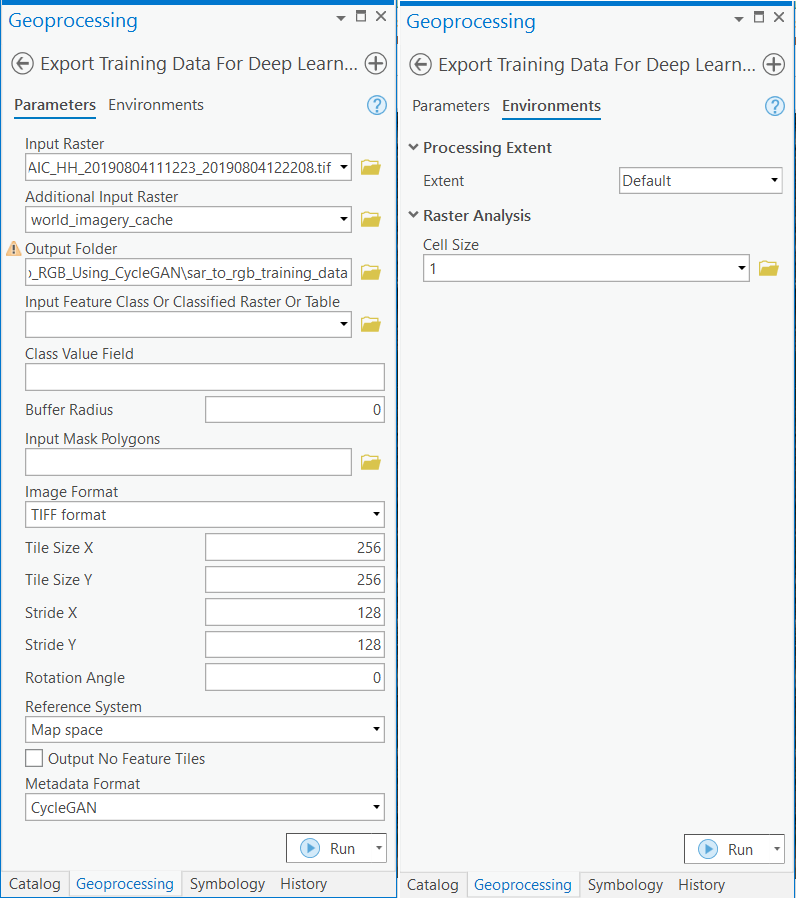


In the exported training data, 'A' and 'B' folders contain all the image tiles exported from SAR imagery and RGB imagery (world imagery cache), respectively. Each folder will also have other files like 'esri_accumulated_stats.json', 'esri_model_definition.emd', 'map.txt', 'stats.txt'. Now, we are ready to train the `CycleGAN` model.

Alternatively, we have provided a subset of training data containing a few samples that follows the same directory structure mentioned above. You can use the data directly to run the experiments.

<Item title:"sar_to_rgb_image_translation_using_cyclegan" type:Image Collection owner:api_data_owner>
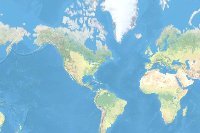

In [3]:
training_data = gis.content.get('25ed4a30219e4ba7acb3633e1a75bae1')
training_data

In [4]:
filepath = training_data.download(file_name=training_data.name)

In [5]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [6]:
output_path = Path(os.path.join(os.path.splitext(filepath)[0]))

## Train the model

We will train CycleGAN model [[1]](#References) that performs the task of Image-to-Image translation where it learns mapping between input and output images using unpaired dataset. This model is an extension of GAN architecture which involves simultaneous training of two generator models and two discriminator models. In GAN, we can generate images of domain Y from domain X, but in CycleGAN, we can also generate images of domain X from domain Y using the same model architecture.

<img src="data:image/PNG; base64, iVBORw0KGgoAAAANSUhEUgAABBwAAAE1CAIAAADLYmQLAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAKBkSURBVHhe7d0FXBP9HwfwBaMEwUBB7MCuB7vBwhbzsQO7u8XCTlRU7A5EVEQxULEReFBAEAUl/gKilMAcc5v8f9v9mGNsyArutu/7xet5drfbdjtvd7/P3S9oeQAAAAAAAACgAggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgAAAAAAAIBKIFQAAAAAAAAAVAKhAgAAAAAAAKASCBUAAAAAAAAAlUCoAAAAAAAAAKgEQgUAAAAAAABAJRAqAAAAAAAAACqBUAEAAAAAAABQCYQKAAAAAAAAgEogVAAAAAAAAABUAqECAAAAAAAAoBIIFQAAAAAAAACVQKgAAAAAAAAAqARCBQAAAAAAAEAlECoAAAAAAAAAKoFQAQAAAAAAAFAJhAoAAAAAAACASiBUAAAAAAAAAFQCoQIAAAAAAACgEggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgBIJD7hC5/PxxMAAKAxv3i8hP99wRMAAKAyCBUAkMi4yTMzf/zAEwAAoDGpqWmTps3BEwAAoDIIFQCQiPvx02z2TzwBAAAak5WdfezkWTwBAAAqg1ABAACkx490H9epVYsGtataV6lSxdq6TmPbNm1F2rRsWKd2/RYdBzg5nwlIgbpzAACVcZ+79Gtn29SmuvB4U8W6Rv2WrfHxxrZRndo2zdr3nbT21KuvcLwBBUGoAIBEAl4Hc7lcPAGAtJyro8oxaHoNFr/g4DlCvKwvIde3/Nu4LKtSV+eHKQI8G4Ci5Obmvg76D08AUBg/elt7Fo1h7nhG8qjCz0kK9d4xuokZq7Ldev9UON6APyBUAEAi0KYCFIX7ekVjPRqz2vT7uXiOBEGKzzQbFqNSP/cYuH4I/g7aVIC/yLw8ohyDbtjDLbFwciCON0yrIWfi4HgD8kGoAIBEdu9zy2Gz8QQABfE/7eykT2eYD7uYiecUJEg62teUzqwxzTcbzwFArh8/slwPHsETABSS+3BWTSaN9c/6MB6eU4Dgy6FeZeh6NgufSd43BToNQgUAAFBD6qmBpnS6of3+BDk1DvhRW9uxaEzrqb5wlgcAqIQXtu4fdDipMeuhjBujQrzwDbYsmp7NoudQZxcQIFQAQCLvIt7/4sm8KAQA+9YkSwaN1dI5VO4u8u1IbwMajdVp12eokQD+gsvlRryPwhMASBEkuvUwpDPKjbgs+8ao8FbFfjt9Gs3A4WgqngN0HYQKAEgE2lQAubgvlzbQozFryr1umH+noujcAQAB2lSAomR5/FueQTe0PyDvxii+U0HT77I7FlprAxEIFQCQyMbNO7Kzc/AEABL4H7a1Z9EZ5UZeycJzCsu9M8WaiU7y3fbGw0ke/EVm5g+XbbvxBAAF5T6eU4tJY7VwfiP3AgXn1qTKDBrdqP/JdDwH6DoIFQAAQAHfTvQ3odONesrqiAXjR2xqxaLRmNVnPMjN4707OfffgfYd23do16Zjz6EzjhYoGwi+XFvUq61tm3adezrOOR2B5wIAgBBxF4JZTXgskQPfqNBruOyVRJuK7Ce7nNCBp1PHDu3bdew+Yps/0WuEIM13de82tq3bte9k33/8vlfQ6ks7QagAgERi4xJ40KYCyJBzY3wlBo1lu/Gd3P1DEL/f3ohOY1iOv5F/M4PzfElDFt2g/db30m0sBN9uTm3Xc/WND9BRlK76xePFxSfgCQAkCZIO9zKi082HXsjAcwpBxxs7QzqNWWPmg0IJIc1rvDWTUfHfKxK3MLjhm7o1GbHrUbzclAKoD0IFACQCbSqAbNzni2z0aHp15vnL7WeF/3mvnTGdpld33uM/vRLzPx/oYUrXqzP7YYGeijNf7Zw8+3QUnN11GbSpAHJlXx1dgUE36LZPbkVKfqwrOt7Q9ZutDpRxTOJHbOtgzDDusC2CuJzBjb4wb9JGGJlT60GoAIBElq1an5UNl46BNP77zW1ZNEbFMZ5y947c1yubsuiMCv2Pxha4K5HpPbkqk1Fu0Mmk/PN5dtDeSVOPvoP6BzouPSNj1dpNeAIACVz/eXX0aKxmq4Pl3RjlBq9tqU9nVhnt8U12UMi45VSNybQedy1NwP1wdt6UnS/l3vMA2gNCBQAAkJzgq7uDMZ1u7OCeLOdKH//TkT7lGcwqg08UGk6b93bdP/p0A9v1oh6h2G8PTp7oGgK9AQAA5CBaZxUx4I0g/uQgCwbTeuiZgpcwJPGjdnUpwzD8Z8qaGZN3vpTXLS3QLhAqACCR76mpfAHcIAZScq6NrcigsdpsjpR9Bs9959qrItOk+cL7qTL2HkHSyYHlGMxqTrdSwt2dxm57Bed3gPD5fHTAwRMAiAmSj/Q2ptPNHM/J7tWJ9+HoAEtmmeYLH6QVebbK8p1Wk0k3snOFHmd1BoQKAEgE2lQAGbhP5tfVo+nZLHwmo/KyIO3V7oE1DCt2XuP3Vd6pm/1oTh09eplarYau9y+6GAB0B7SpALLlXBtTkUHX77Jb1hiaWW/d/61nVL798rvybpvm40ScmNKuqiHDsPVGGDdHV0CoAIBEZs9f+uOH/GEIgE5iv1zamEVjWIy7XrDSEi/t3W3XWd2qV7AZ6HwzukBDbGlsr7EVmKYOR+QOYwV0T1pa+vzFK/EEAPkybjlVZ9L0Gq94XSAKCLI/PT62tG+9irV6rbj6/m8VKNlh7jOmuAYm3ZlWk8mwGnVFTssLoGUgVAAAdFvu17DHNy8eP7Bjy7Z9J7xexYtL54KM4PsvxM2bSx735daBHdv809DalEmn0eisija2bbHWrWxtWzRt1m7A9M3nn/9ZY3m4AcsbsQy67o2DEzsAQDbuM5d+7Vu3rG9pzBAecIytm7TGx5s26HjzT7OmrXpNXHv8YczfuxJhhx6eNuVAsHBBfvQ+O1OGge26N3L7rSMJfkb0C58rJw/u2Lp9/2mft1/z1xedBx6+gm6riglCBQAk8vPnTwG0qSgp2e+9XCZ1b2hp1aTv5CXrdx05c+7k/nVT+3bqvfBqDDcvO3B79xr9jsqtUkQh/E+7OusX1ZML0EXoUPOTA32AATXLDnGbPt3tjfhWRvaDmbX1GJVHXiJrwVyQHnJmxbC2Naxs7MYtdN55+PTZ43tWjevebbTr6wwBJ8zVoa7j6TS8LPgLCBUAkAi0qSgh7PeXF9lXNzZvOmaPX6zUhf7M19v6tB/m1Ntaj9Vua5Tcvk0o5NupgWWL6MkF6CZoUwHUjR3jtaR7nw1BBSpH8T/t716Wod9ybTD5blZw3l+a38W6jFWXRRdC0woc7PkJXlO79ps4qLa+foft0dpwHigRECoAIJEJTrMgVGgaL+H28k4WeqbNp136ILviEP/Dri7CYeTqL3lJ9lv2f5H5aIfT2OFd65Uva2ZtO2D0lH0v/lpVCugKFCqcps/DEwCoQpB2f9O/fdrbVCpbpmztnttf/rmAkf5go2OramampmaWTXuOdNr3gjTXNgTf/DfYW7LM2yz2+SLzJm6617gqTOF54AXFzwMlCEIFAECHCFJuz2liRGfVnXjti/yb8YIv++0MmFaTblGvCH758mV/f388AQAAGvP58+eDBw+y2VS8VJET6NLJnMGq63RDfi9W7BvjK+lVGi/VQwYoAoQKAIDOyH27064Cg27QZJF/0WM15N6dVs188BmqVaS9du0aTeTNmzd4FgAAaACXyyWONi1atMCzKEOQ5DW5LovOspnzoKhxvvnvNrYy66MVDetKCoQKAEhk0tQ5UP1JY7hvNrUtQ6cxq0/2lj2m0x/cJ/Mb2u2h1pBNubm55cuXJ07zHTp0gBb/oGipqWlTZ87HEwAoaNu2bcTRBgkODsZzqUCQdnNyDSadUWno+aLH2uDHbO/a0SUCGlQUH4QKAEgEGmprjiDx1OAKDBrdoN2Wv58k+FGX9nl+ota5xMXFBZ/hRU6dOoWfAEAWaKgNlJaQkGBsbIyPNTRa27ZtqXMVgxe2qbUhXTSaaC6eJYcg6fahixHQaZ4CIFQAQCI5bDZcYNYMftS2DuhEQjfufiBeC7dwXFyckZERPsOLWFhYpKf/7Y4M0GHoUMNm/8QTAChi+PDh+ECT7/jx4/g5kuM+W2ijR6OxmqwKgrigdhAqAAA6gP95T1cDlCn0O+2k2A2I4nF0dETn9Q4dOqD/6unp2draogdz5sB1aACAmt2/fx8dXvT19YnjTPv27dF/K1SokJZGgVZovODVTVk0GrP2XH/o00n9IFQAQCJzFiz78SMLTwA14niNrcBA5e16C59p35nE19cXndQNDAyCgoKIB69fv6bT6QwGA1psA3nS0tIXLFmJJwAoHi6XW79+fXScWbNmzciRI9GDY8eOtWnTBj2YOXMmXojE0k8OMKbT6KaO54rurAMoBUIFACQCbSo0JfWogwE66+n3OpyC50jiBu507NShU5du9j16OfTp26dXD7uunbtNPRtHgZsaubm5devWRd9t/fr1aWlp6AEKFWj+1KlT0WNosQ3kgTYVQAlE++waNWqw2WwiVJw4cSI4OJguQvoW2/yY7R1YNJpeA1mDEPEjj4zrgk4EdvY9eqPzQO+e9t06d514HIa+Kz4IFQCQyLdv3/lQBNSEnAtDTISXp4ZfltulOp+TmfR8la3wzrj1v2djsilS35Zon127du2fP38mJiaix3p6emj+9+/fic6goMU2kInP56MDDp4AoBjE7bNv3LiBJrt27Yoeb9q0CT2eOXMmekz6FtuCZLfu+jQaq7XcTp3QiSDBe3o9PRrdpOuWkDQunJAVAaECAKADeEGrmqC4oN/zcEoR5wiO71RrJo1hOdGbOqM5+fv7N2rU6NatW+hxTk7OrFmz5s3DwyQfOXIEneP/++8/YhIAAFSRlpY2bdq0fv36/f79G02eOHECHXBevHhBPFWnTp19+/ahsCpalqRy706ryqTp2SwuYpjsjAtDzel0/a574yBRKAhCBQAksmLNhqzsbDwB1In7allDFh3lhZvyR0flvlraQI9GLzvodCqeQw08nuy7KgIRPAFAQekZGavXueAJAIpN3gFH3nxyybo5sQqTbmjnKrcbQM7dadWY0D2UUiBUAEAi0KZCcwSJ54ZWZjDMex6IkXMhLdN3Wi0mja7feddnitahTUtLYzKZxsbGeBoA+aBNBVDRqFGj0AHn5MmTeJoaeKGb25VhGLRYFcDBcwpKvz7BmkljWjvdkf08KAKECgBI5HNsHDUu9lCS4NvdxbZmTNN/5nh9LjToUUbQgWHt2/5jzWQ1pe71KcmG2gAU7RePFxsXjycAUJy4oTaepgru+yODrFmG9Sec/yCVG/jJT3c4dmzdrBKz7OAzFOggl3QgVAAAdEhmyPFZXauVMW/QZ5rz7qOXvO/f975wwHnG0F69Rm+4FctJ9JzqsMz/L8Osktfv37+zRPA0AABozM+fP9HR5tevX3iaQrifrq/sU7esef2+M9btO3n19v07nse2zP+3p/2I9T5xnOhjI0cfoOoN61IFoQIAEtm0dVdOjvw6/0A9clPC759z3bx22aLFK9dtO3DublgKZXMEAErKzPyxZcdePAGA7uF+e/fg7D6XNUsXLV2zaffxm4FfqNNDB0lBqACARKBNBVBFenq6hYVF1apV8TQA8kGbCqCiqVOnogPOhQsX8DTQeRAqACCRsPCIX9CmAigL2lSA4uNyueERkXgCAMVRtU0F0BgIFQAAnZCRkREQEHD69OkVK1aMHTu2X79+HTp0aNiwoZWVVZUqVWrWrGljY9OkSZPWrVsPHjx47ty5O3bsuHTpUlBQUG4uZepG8fn8OBE8DQAAGvPt2zd0tMmmTjfov3//TklJefLkibu7+8KFC0eNGuXg4NC2bVt08Le0tLS2tq5Vq1b9+vWbNm3avn374cOHL1q0aO/evZ6enu/evSP5+BskAaECABLZu/9QDhtqdaqHQCB48+bNvn37UEhAJwyaslgs1j///DNt2rSjR49+/PgRvzsAFPfjR5brQXc8AYCW4nK5z58/37x5c8+ePcuVK4cP64ozNjbu2LHj/Pnzz507l5SUhN8dFAShAgASgTYVqsvKyjp//ryjo6PU+YPJZNrY2AwcOHD58uWHDh26fPnyvXv3AgMDUU6Ijo6OiIgICQkJCAjw8/M7c+aMi4vL9OnT+/btW7NmTfz6fHXr1kXnlfv375PwDkZGRgZxmQ1PAyAftKkAKlq4cCE64Hh6euJpMvn69aubm1uPHj2MjIzwsVvEwMAAHSGHDx++du3ao0ePXr16FR3z//vvv5iYGHQuePfuHXr86tWru3fvHj9+fN26dZMnT0ZvUqlSJfz6fC1btlyzZg1aEu5gSIJQAQCJvAoI5HK5eEIzNm7cOJJMHj9+jNdMNWw2G+WEIUOGGBoa4qM+jWZhYTFs2LCDBw+GhoYqvWG/f/+OTjAoZgwYMKBMmTL4rWk0ExOTiRMnPnny5Pfv33hRFaBPwVtEBYMHD0YrxmAw8LRqYDRuwtSpU/EWIQeUgfGaqQal4oDXwXhCMzZs2IBXmhz8/f3xmum87du3442igmrVqqEDTuvWrfG0CtAxFq+ZalJTU93d3e3t7dFhUHScFqpZs+aECRNOnTqFYoNyGQAd5P/3v/9dv3599erVdnZ2LBYLvzWNhvIGCldhYWF4UZW5urrijUION27cwGtWDBAqANAt6ICIj4XkoPporJ8/f168eLG5uTl+RxrN1tZ2x44dERERainuS0LlsAcPHixYsKBevXr4w0T3LlDkQKccvJBSEhIS8NuRBlyBI6BoircIObx+/RqvGel169YNrzQ5oGIlXjOd179/f7xRyOHAgQN4zZQVEhIyceJEAwMD4g1RqEDR4siRI5poY/bjxw8vLy8nJycrKyvi4xB03nFzc0tPT8cLKevff//F70gOW7duxWtWDBAqACCRoyfOsNk/8YRmEKFiyJAhqDRfuogDFnqA10xBKDA8evRo0KBBdDqdeKvGjRtv3rxZXddx/yo0NBSli4oVKxKfrqenN2nSpA8fPuCnFSQOFcTGKUWHDx8m1gRCBYEIFc7OzngDlR7i30VdoSIrO/vE6fN4QjOIUDFs2DD8BUoPsekgVIgRocLBwQFvoNJD/NMoHSp4PJ6Hh0enTp2I90HQ44MHDyYnJ+MlNAmdhp48eTJhwgRjY2Pi001MTJYtW/b161e8hOKIUIG+Bd5ApQd9F7QmECoAoKoSaFNBhIpbt27h6dIzUtQdITpy4WlFoDjRvn179HKEwWAMHTpUXdWQFMXlcq9du9avXz/xyqBTgrxb4UUMPUuEivLly+Pp0pObm0t8FwgVBCJUxMbG4unSg2IzWhN1hYoSaFNBhIrbt2/j6dIzfPhwtCYQKsSIUHHlyhU8XXomTZqE1kSJUCEQCC5evCi+aWxkZDRt2rTw8HD8dMnKyso6fvx4u3btiJUxNDScO3cuOqrjpwsqegxyIlSQoaNe9BXQmkCoAICq/B7552q4TQXVQ0VAQED37t3RCxEzM7Ply5fHx8fj50oVOpmNHj1aXJF30KBBgYGB+Ll86Mt+/vwZTxQEoYK0tDVU/ORwHj5+iic0A0IFaVE6VPz+/fvmzZvNmjVDL0SqVq26Y8eOtLQ0/HTpQSvm7+/fo0cPYsVYLNbUqVNjYmLw0/m2bNny86fcKgkQKgAAlEHdUBEXF0c0REaMjY1Xrlypeu1VtYuOjnZyctLT0yPW08HB4f379/g5UWcpo0aNwhMFQaggLW0NFSUAQgVpUTdUBAcHi28IVKpUydXVlcPh4OdIIyAgYMCAAcRKMhiMiRMnSlaIQqkD5Qo8UQiECgCAely47PlTw8dHKoYKHo+3a9cuotKqvr7+vHnzVKmxWgLi4+PnzJlDNBlksVhr1qwhrkv169ePTqf/999/xGKSIFSQlraGipycnEseXnhCMyBUkBYVQ0V2dvaCBQuIu8Hm5uaoXE7ycffevn07YsQIotUfWuEjR44QXerVqFHDzMwsNTWVWEwKhAoAgHpAm4rCgoKCWrZsiZZE+vbtK6/6EAklJiaOGjWKWPPatWv7+voS1X979OiBl5AAoYK0oE2F0iBUkBblQoW3tzfRgy0yffp0Et6mlic8PLxLly7Emrdt2zYgIIDIRQsXLsRLFAShAgCgHje8b3M4mh1SjUKhIisra/78+cTx19LS0sPDo1SaYqvowYMH4qaE4o6q7t27h5/OB6GCtLQ1VLDZP719fPGEZkCoIC0KhYrExMShQ4eiZZBGjRo9f/4cP0Ed6Mx1+vRpoqtA8VlAX19f5lEFQgUAgDKoEirQGlatWhUtgMyYMSMjIwM/QUEcDmfRokXiNtxIy5YtpQIShArSgjYVSoNQQVqUCBXoIHno0KGyZcuiBQwMDFxcXDQ9OKxGpaamDhkyBH0XsbFjx+LnJECokMQL3tixsrm52d+Ym5e3rFG/eTuHccv2eYakwLkLFIP2713ePr5wp+LXr18LFy5ETyGoFPXixQv8BDWlp6cvWbJEcpxvwvnzBYYIgFBBWlp8p+LWbfUMYywPhArSIn+oyMjIEPfMYW9v//HjR/wENcXFxY0bN07y0hJCp9PfvHmDl8gHoaIAbkpU0Kvn/vdvnlvTo5Jo69ENm045fvfpy1cBYi+f+t2+enz70rFdapRh0Ol6FW0nugWkC9uvAFAErd+7oE3Fly9fOnTogOajg++6desofV0K8fX1rVKlinBPLaRmzZqS3w5CBWlBmwqlQaggLZKHClTUrlOnDppvbGyMzhFUrPgqyd3dnRhIrrDevXvjhfKpNVQI2Dls/FBx5Kr+lHNtbEVhsY9uaOcaL7dEx43zWWNnpUenMcxbL737FXIFKBZt3bvOX/LQ5d6f/Pz8iAIc+i96jOdSHDodxsfHP3jwwM3Nbf78+X369EEnSyaTib7m3r178UJqDBVZ0VEJPPxYKRAqpGhrqMjJybl4xRNPaAaECtJSa6hQ6aBTOFSg8jRxa7dBgwYRERF4LsXxeLyPHz/6+Pjs2bNnxowZ9vb2VatWJdpXSJ3s1Bcq+HGeU5pU7bzuaZpypR9ShQruk/l1RV21s1o6hxa9t2W9dG5rirYs02rImTg4i4G/g71LeaQNFenp6aampmhOx44dv3z5QszUVr9+/Xr//v2zZ8/wtLpCRU7wrp5WJo2mXEtQfl+HUCFFW0NFCYBQQVrqCxWqHnSkQsWbN2/QJILK1iTvMVZ1bDb77du3ISEheFpETaGCF3tlcuPqneeuGd+sWidnf2VyBZlCBT/CpTVLuF8wa8z0+2sdcfbThfVZwoKf9cQbFG6OCUqI9u5dfo+e6PKI2hcuXFi0aBEqcONpXaKGUMEJPzS4Zff1foHnJ7fusOCOsrfmIFRI0dZQ8ZPDeeT/J9ZqAoQK0lJTqFDDQafwnYp169YdPHiQ6lWelKaOUMGNuTChRfMxJ96x8/IEqU9dejbssuZxqqL/OiQKFYJkdwdjVI6jMcyHX8rEM4vAC17dTFhKpJftfVh+bRYAhLR474I2FTpL1VDBjTo11m7k4bc5wglB0p2lPR3WKHVxCkKFNPWEiszAA8t3+H9T6QCka20qBOysbJWq8v0BoUKKOkKF7IOO6CkFyGuorbNUDxW8sG0DHZz9JCIeJ+q8U3cnjxTFjj8kChV/qrzbH0gozrfg3JpUWfSCsoPPKLxPAt2ixXuX+/HTbLZw6GXNgVBBTqqGCnbEo6dxEgUwQXrww1dK3ayAUCFF9VAhSHu6oZt11bo1rFovupOszD8KQb2hIis7+9jJs3hCM5QPFRmvXKcMGz116oAWDXq7PCk4zpngy41lA3pNPROtwP4JoUKKOkKF7IMOnig2CBVS1FL9SfmjjATyhAru0wXiKu9vi3Whgft6eSPRK5g1Zz/UbJeagOJg71IJhApyUltDbZVBqJCiYqgQfL27rL1N15W+ibzUp1v62NjOuBav5IbVlTYV/E/H/u2/9kUmOnYHLGvIMmi/LUpii/E/bO+gT2c1XR2kwF0MCBVS1NpQWyUQKqSoqU2FGpAmVPAjXdoQVd6rF6PKuwgvaHVT0UvopsMuKd8BFtB+Wr13BbwO1nQnqiqGiuzY175e13yDE/P7qOKnRz/38br1PCZT0UsjECokQaggLVVChSDRe26n9k7n3uf/XrixXvO7tJt06bMy21a9oQL9Q78O+g9PaIZyoSL9ulOPZS+EW0yQcmKAKV2v/pIXf46Kgq9H+5ShM6tNv6/IBSIIFVIgVJCWSqFCwE5+/yYsLkOBwC0fWUKF4KtiVd6Fcn2nWAv7WKTRDPoeL3irEwAJ2r13kbpNBffztaVDBk/b5H5i30L7uvVHnojMTX20ady45fvPnd81vnkd+x1BeMnigVAhSdFQkZv5NflbWmY2h8vNZWdnpKUkJ6cX6oyYn5P6VbRQLicnIzUlLac4wQ9ChRSV7lSwP4S8kx4lJ/t9SGQWfqwQnWhTIUg5NbzX1kjhvidIOtq3LJ1ZfZqvqNY+IfvamIoMRrkRl4t5+CdAqJCiXKjgZX9LTknLQEcU4WEnMz31a3Lqn6NK/rPs3FxONjrgpGQUJ/dBqJCidKjgf/FeMXTo9LXrJrWybj7LK6nAcYcfdXx0i4b99oUrEDfIEipyvMZa4Crv+4tV5R0dO5IP9TQQlhRpdNPhl+FOBZBLu/eu3fvcctiaXUNlQ0X6gyX9Jpz9RByQ+NHb2uubdx46aNCmEE4e/4OrvRmDxmrhLHqyuCBUSFIsVAiSr69w7NOtaWV94Y5NZ5at1bbX0HW+UomZG7RvWPNKwq7P6Hpm1Vt2n3X+UzFiAoQKKeppqK0O6g0VP35kuR48gic0Q6lQkfH2SZConxr+p73djKXuU+Rx/efV0aMb9TyUWLzDPwahQopSoYIbsGdMv+6ta5oyiBOqvkUj+1kX8o8qHP+N3euUFZ6eaXSWeW1bu6HbnhbjbAahQoqSoYIbtnPQENcI9FvhvlzaQI9luz5MIj/wwjfYsmhSM/+GJKGC+3RBPaLKewvnN8Vc/dyHs2oSl5L1Gi59pdnqH4DKYO9SlXKhgv1sWY8pEj3yph3tY0BjVBh6XtibDff16maGLItO61/gZ4sHQoUkpao/5QYsb8yi0Zi1Zj+Sc0kw99mi+hVtZ50NLf6Y8hAqpGhrqCgByjfURviRW9rq06WO9Lyw9cKyUWuXCMV2TggVUlSo/iRIuTDcgoGCQ7utkm1dhLjPFtqY2gzZevdz8a+NQaiQolSoQP8oo3tvELUyFSQe6oXCeKPlARKVBhMP9jCkM2vP9VekBESOUMF/vzm/yvuMB8Ws88iP2tpO9Boa3XzI+cJjCQjSXp3duWPvwSPHTp46dfLEMffDB/ft2r7PW7LzB36Mz/5t23ftQwudOHHs8IG9u3aeeankMIKArNS1d2UGXdy1fefe/YeOHj958rj7oQNof9q60yNM1oGQHe65Z/uuvQfQssfd3Vx37b4QqNB9d0W8i3j/i6fAhQQlKBUqcq479XQO/rNi3FdLG+rRyw46nUpMC9jpGQoPBA6hQpJybSpEl5/oNGbtOY9kbf+coC2D+m94WvxAIQShQorSoYKX8GDXzDGjJ4wd0rNLjwk7H3/l5wkygo8vcZo81WnCv45DZ7q9Uqw2pnpDBZfLjXgfhSc0Q5VQgTNF87WSmUKQsN/ekK5ns+i5gleHIFRIUalNBdtvVi0mjW7UZXeBHrhyww8O6T7Hu2C1m7+CUCFFmVAhSHIf0t9V1FJLELvfHmWKOvP8Jc4JmZdHlGMwKo65ptBogqQIFUQjKrQedPNhF4tZ9hIkuxOvodGNe7h9KbxDCpL93TeuXTrNwQYvxrJqO2rh9luS9/K57y6tHNxA+DydWbZut5HTl2w4HaDYyRSQnbr2LsG358c3rV06tWcdI9EzDIvWYxau3e4ZISunZAWdXta/rj6dRtev3LL/5EUbL4RobJRPsrapEKTGxkk0xBYkuvUwpLM6bFekT8dCIFRIUrKhNj9qewcDlCqqTfWVTsSCBI+p/efdUrhbWQgVUpQLFZwwt3/7zLpANJ4QxB/tV960/YbLu0aM2BGUlcf/dH5SE3M9VquNomWLSyfaVGDEQUbPZuEzyfiQfn6IOZ1hOclb0UqiECqkqNZQmxeytgWLXqALLn68h1PPiec/K3xRDEKFFKXuVOREv40SlYn477e2N5DuHC3Xb2Z1Jr1M32OKDVRBilCR4zWOqPJuYOda3IHGUs84mhOlPlOHIzIyhRg32PkfYeV4huWYq4Wv8AhSroyyNm824cDTRF2v4qKt1L135TyaI+qdlmk94XoRg21n+i9sbNZg7NG3GrtDkW/j5h3Z2RJtEjVA+Ybaf2R7jqnAUOJqYUEQKiQpGSry+LGudsZ0GsNqwo0CbX+zX20aPOJAeDFv50mCUCFFmVCR82xlr9Fn4sQbkBeyphmLzjBqvSEUneoFX/bboTMZo6KjYsNEqDdUZGb+cNm2G09ohgqhQlRrlW7qeF5yt+bcmWLNVGq8IQgVUlQLFSgW7xMed5g1pt8VnrAEqX7LHRz3vlU06wlBqJCidENtIVH9QDqr1cZ3EpkCZcDmaGb7bR8UO6STIVRwny3EVd4L3rQsgiBR2MGD8DVMq7GeRR8rBCmX/7VEpUq6UVuXgs1NhKML2Tfvv/u1xst9oNSof+/iv9/RSXizgm7a/YCcPh5z3x8b2qLbmodKjSNGQmoIFaKGLYwKoz1Vu2MDoUKSsqEC7eJHHExRAdXi3yviKy382AuT+y/yVW74ZggVUhQPFYI4twF2GyVH0WHfGF+JQTfstjeW+DfJjvS94PkiXsEymC61qch9MLM6k2k95Y5ELs55OLuOHt2g6944hfdsCBVSVAwVqDB2bkgFBgrGwy9+yw7eNdhh5SMlq5tDqJCiSqggKsRKtccWxO7takDXa7hMopFFsZAgVPDfb25LVHmvVtwq7/z32zsYCkt9dKPWBY7CsvHebmglXJxhNeqK+JQp+PZwdTfbkSciFa7WDShEE3uXIPXyyErCmMpqtFxGG27ep/Nj/+m88pGoL5ISEBuXwCNjm4oCRCOF0A27H5TofkWQFv1BsRurECoKUjpUoLP76UHm6OxezvHcN9GMzGfOg0YdiVT2NpLMULFv3z4ytFQuFYqHCn7sfa9XkpVveUGrmgq7XtmgSH+Ohak3VPzi8eLiE/CEZqjSpiLt8r+VGEb2+/PvSXNjrzo1MKAr0keHhMKh4tevXxs2bMjKUqpzX+pTNVSgYHxnajUmjW5sO2Bgz2meCUpfgYBQIUWFUCH4ckDY5qhgh2l5aWcGl6UzrZ1uK1pCLv1QIUg51hdXeR96oYjqJBIybzlVF/bMQ2c1XPC4OBc+BameY6qgV9ANWq4NFm43Qcr9ZZ1tx52LVvYcCqhBQ3tX7oslDYSdbjIsR18teCeDn3BtSqu283ySSyhRIKQdpyI3NTEFX1UVJB/pbSyssinRcJvzdJH9LIXGokIgVEhSPlTk5aVfHlGRQaOX7Xc8ScCLOT1+wPKHKvRRUThUXL16FU2WK1dOudIh5aDi5g+Jn6HSDbXF+J93d9an69Ur2D5AcbrUpgJttfjri7tWr951/oHTx3aucBo5YcGoFvp0Zk25XZ0VpXCoWL58OZrToEGDd+/e4Vlajc1m//z5E0+oI1TkcV+vbCLsJgKVVpWp9pQPQoUUFUJFrt+sGky66ZALBSoN+ky2YtDNHM8pPEhX6YeKnOvjhFd9i1/lnR2w1lZU+8Sw2dInxb1gwAvf3Fb4IkZFxzNfku4s6mA74QLuPh9oMU3tXfxPrvYmwsXKdNvzp+GxINlnXltbJ8/4Eq0BsmzV+qxsjTUDF1EiVGQ9WtLMhKHffI2w5Zcg+Vi/snS68aAz4k0q+HZpfO/1ooivCAgVklQJFXlZ18dbolRRpvvWC8sHjD3xQaXDYeFQ8fXrV2K3QVavXq1N1aJ+//4dHx//4MEDNze3+fPn9+nTp06dOvr6+mFhYXgJNYQKQcqJ/iZ0huVEhZsXS1FvqEjPyFi1dhOe0AyVQoUIJyn8+f07j98mZPFSTg82pzOtp9xWptVZ4VARGhpat25dNNPY2Pj8+fN4rlbg8XgfP3708fHZs2fPjBkz7O3tq1atWrly5WyJk4saQkVe+vUJwmFl9eoW6GhIURAqpKgUKmbWkK40mH1/Ri2mIu1Q/yj1UCHsoliRKu/ZL1eJCn2MSr33K9SgMP3GROGuTNeztmn8z3hIFDpBg3tXxvXxohG3hT2NiI6Ngm8PV3RsMfpsjBbuWYqHCtFIOjSGeW+3T/y8rCfLeg90bGdq0G0fPkRx3x8dPdD5ueJRCEKFJJVCRV7O7SlVmcIh7tqsfFK8u3jyyaz+hIopq1atIuZ37949OTkZP0FN6DuuXLmyadOmRkZGxJeSNGHCBLyciMqhIsvj3wqMQs2Lc9ILD4H+FzrTpoKb8PTk5nWHnkhUqeR/PtDdlK7fdEWAEvcp5LSpyMzMHDJkCJqPoMK35IV8Kvr27dvEiRNtbGxYLKIT9QKkSu0qh4rciCMje0+c2FnYoMtqnJfyhx0IFVJUaVOR5jGqMtPIzjW/1RH385XJNsJKgy2d/966oJDSDhX8qC35Vd6n/70mRG7UyeE1WXS6nmWPLc8V7fqVH7m9o7Hw4rKxnStu+Aa0m0b3Lm7wmuaiKlAWwy9+42c8X9+tmeMRmf3Latj31FS+QLM7tBJ3KtiB27vXbTl+24kjm6c5jtzyNC33/ckxjev3Xrrfff+aSQOGr7n9RZlL1xAqJKkWKojhUpm1Zj9UvV2ZzFBB8PHxKVeuHHrK3Nzc3d1doOF9VaN+/frl5uZWqVIl4suKGRoaon8LvJCIMqFCwOOJNx7RZZFBtwLNizNvTbVb+ETBu3vqDRXo3xcdcPCEZigXKvgxe+3K0Gl0owGn8ouqgtRbTrX09OvP8lWyYp+8htq/f//es2ePnp7wglXt2rXv37+Pn6AmFJNWrFhROCrXrVsX7fB4IRHVQgU//uqUnhPOfeKlXx1dmUGjm/c/ruDoFH9AqJCiSqjIEyTcXNKtRvUu8w6cOrpzudOIiQvHtNSnFzE+alFKOVQoUOWd//Wxi4M1KvMZ1ht1IkKJsyA//uK/1YjK8vUXFmcgeEBxGt67BAnufcyEKdWo9eS53Zs47A7RbL+u8pC2TYUg6/MrX+/7QfHZ+WcOTnK4v4/3g6B4pbcUhApJKoUKQcrxfmXojAqjr6qh7lwRoQJBZeuuXbsSC3Tq1CkiIgI/QU0pKSnoWxBfh7BkyRL8XD5FQwUv4tCg6oYGVYadFnVhne3jZM1EgW+OxFmd/2F3317bFW61rSNtKrhPF9iYW9s6bvbHCYIXc3ZEDUPr/geU6rJURF6oILx48aJevXpoAWTMmDFor8BPUFNISAgKSMTXIRQODyqECkHqw+UOjrvfiP4xOI/n1tFDZ85OO6RH1y4uCBVSVAoVIpykd/mVBr8RlQadlKo0WMqhItNjVMW/V3nnJb9wn9OlCovOLNdi3N6nyUrshvx4z2ltO8zet7SDsJTJMO9zRPH+5QDFaHzvyr4zVdSmm1Gu88aXpdYv8ez5S3/80GxvJMqFCk2AUCFJpVDBvjXJkkE37CHZIZfSig4VyO/fv9EJj7hlwWKx1qxZw+GofoOkFKBfQc2aNYkvS0BfKj1dujmjgqGC6KWOzqwy5mqqII8T7OLQvX/XyiyriTdx4hN881vZb9j+MMWvHKo3VKSlpc9fvBJPaIaS1Z84QVv69l5w+e23XG5m7PPTS3o2th298+EXVVq5Fx0qELQPoz2ZqDiEfoZoD0f7OX6OOtBvFpXOy5Yti74FnS68DIe0bt268HdROlTkBO9y7LvqsfiOES90na1wHLzGyxXtsBSDUCFF2VDBTXx5dvumYy8kuhLnxx7sWZbBarzspVIVL0ojVOSmxUdHvX8X8vzWoSktTUW7MMNy6JHg9x8kRL1788rf58KBdbMc21gbMRjGVdtP2PkwQakdkBtzYWKrjgvvJAvyMu9MrSlqWWEz73HpXFcGmlWSexfvrXNLdDrRa7zitSqnLvKDUEFOqoQKbsDyRnrCrjaVqDVb2F9DBSElJWXMmDHEkvXq1Xv06BF+ggrQ1nZ0dCRW3sbGZvv27cRj9AAvIUHROxXccLdBdWvZLzly9uiWGYMHL/f+wvvqu6pbvRYjN7ifPOIya9jgGe4hSl240Jk2FaiMH/fw6IbFs2YuWu96zickSeWD8l9DBSEiIqJjx45oSQStfFRUFH6CCoKCgmxtbcUrv3DhQuKxzN+mcqGCF316fO8ZXgVGkRXEHuhuIhzVf8ptpW6UQqiQolyo4H/eL+xxRrLSYF667/S6LFa9qbeUG7KoFEIFP2JLO9EoAH9BZxqaW9dt2tZu4MSVh29HpCt5lwwlinNjbTstvY/HIeNH77MTFjXpZj0Pyhm5DFBXie5dgi8Hu6MPY1addlepRK8mP3/+1HQ9dQgV5KRCqOB/3tVZn860VtO+W8xQQbh37564osWQIUPIXxsqMTERFbaISucGBgabNm1C3zcuLg5NVqtWTeYtF2XaVHBTIp7eueMfnvzn/XK+vH3ie+dRyJ8qhApTb6hAh5qfGr7FpHyoULdihgoEbRZ3d3czMzO0vL6+PipXkb9bgrCwMFQSJW5NoN313Llzv3//9vT0RJMODg54oYKUCBW5UWcndBtxNKpQwku9OLwig8Yo73hW0cGKhCBUSFEuVHCfzK9nUrFBb+cHOEHwE65OqGtQucfOQKUrxZZy9SdN40afHduq66qHkpEr2292XT30O9KrM8tPDZWJgc7KujKyHAPFUyW6clYn0rap0AQIFZKUDxX82P3dy9DpBr2PqKciuEKhAmGz2StWrCDqjaBizbhx4z59+oSfIxOUCmbMmIGKicS369OnT0xMDPEUKoEZGhrKK3EqEyo0Q0faVGhC8UMFAQUJomyHGBsboz08La3gOEbkEBgYOGjQIGI9GQwG2sPF9fdQ0kBzQkNDiUkpCoUKQc6XgHNL7awNqk+/LyOG8uNc7Y2EF8k7bH2n+D0lCBVSlKz+xH7p3LPvap+YbEEe91uo57qBTZsOWuf9SZXLBtocKjgRx0fa2jn7S49szI893NtcOCCyqd2+P2MMAKCY3EezazFpdP0uu0v3ltcEp1kQKnSTEqEiy2dJ19at/2lYtYK5ublZ2XLW9VvYth91KFLFOlCKhgoCKnNPnDgRFWLQC/X09KZNmxYZGYmfK21RUVETJkxgMoWNphAUJ54/f46fyzd69Gh5Nwm1OFQ4TZ+HJzSDuqGCgDZ1z5490QsRMzMzZ2dn8ty1ePr0aa9evYh1Q784Jyen6Oho/JwIh8NBP0k8UUhxQwX3xaYe9a3MTcuiY4yJsaGxRbMFkrWcBF89ZthWMzcyMkELmJuZW9Vrbttl/nVF8heECilKhgokK9Jr55IZTpOnL9548OKTTyo3C9DWUCFIeeLSq37HNU9kdg3KfrqwvrA3UGbNab6abeEKtBYvbL0ti0ZjNV0tHN5Nu0GoICdV2lSol3KhgoCCBFF6I6ACmY+PT2n1PIs+9+HDh2h9xC1WhwwZEhwcjJ8uqIjr0NoaKkoA1UMF4dGjR+3bt0cvR1gs1tixYwMDA/FzJQ79PFES6NKlC7E+BgYGs2fPjouLw08XVMRerXRDbbWDUCFF+VChbtoXKvgZH+4fmN7Z2oBRpu8xOZX1uInXJtUS9S5bpp3zqwy4WwEUJch8sbwFCqaMcv96aH+LfwgV5KQdoYIQEhIybtw48QhcderU2bJli7iuUQlAAWD9+vXinp0YDMbo0aPfvXuHn1YQhAqlaUeoQH7//u3r69u7d2/0JoS2bdsePnz427dveAkNQyvw33//zZkzh+h1DSlTpsySJUuSkpLwEgqCUEFaECo0IsdnZv0KZqZlzStYWFSsUK6ssWFFB+GAvgVwnyxrZm5sYlaufIWK6MBfsQL6X+WqdluKM+AyANxXzh2qVqliaVGhItp/KlasUL6CReXK1m3XviytDqAmTZ0D1Z90kzaFCkJycvKGDRssLS2Jd0NsbW137NihodI5KnWFh4dv27atc+fO+PNotEqVKi1evPjjx494IaVocfWnqTPn4wnN0JpQIfb+/fvZs2ejAj16N4TJZPbs2fP48eOpmhlGkMfjPX/+fOXKlU2aNCE+EbGxsUHlvO/fv+OFlAKhgrQgVAAA1AMaauss7QsVBC6Xiwoujo6OBgYGxNsidevWdXJyOnv2bHx8PF5OKQKB4MOHDxcuXJgxY0b16tXxu4uqmA8ePPjmzZtSowgrR4tDBTTUVk5mZuahQ4fQtxPXrEMPWrRosWDBguvXr6sYMNBOGxIScuzYsVGjRonvSyCmpqZTpkx58eIFys94URVAqCAtCBUAAPXIYbM1XQEdQgU5aWuoEMvKyjp//vzAgQMl0wViZWVlb28/e/ZsVKq4f/9+WFjYly9f2Gy2VMkJrczXr1+DgoK8vLxcXV0XLVqE9mRikC8xc3NztFOdOXNGvZVStDVUoEMNm/0TT2iGtoYKsaSkJLTfdurUieiiQKx27dr9+vVbvHgxygZPnjyJjIxMTk5Gvyz8MhG0h6P8gH74KCdcvnx5586dM2fObNOmjdQPpGrVqtOmTUMJOSdHnbVzIVSQFoQKAABlQKggJ60PFWIcDgcVszZu3IiyhKGhIfFZhenr66OtgWIDWkaqxCapXLlyPXv2XLVqFXpPHk8jFV+hTYXStD5UiGVmZvr4+CxdurR169bifsYKMzIyQnu1iYkJSg7iuxyFoSAxePBgVJgLDQ1Vy32JwiBUkBaECvVgs9noC1y7dg1PA6A+qMAxffp08o9hNGfBsh8/NNuJGYQKctKdUCGJy+W+e/fO09PTxcVlzJgxqEBWq1Ytc3NzmeUtVCCzsbHp3r37xIkT165d6+Hh8fnzZw0VuSRpa6hIS0tfsGQlntAM3QkVkrKzs4ODg8+dO7d69eqhQ4c2b968WrVqKEigFSjMzMysSZMmffr0mTZtGvoVoGRSMucpCBWkBaFCPRwdHdHaI+Qfk5UMeGnvfE/v27x64fRxQ/v16j1g6Pi564/4vMsoUHWGG31h2aY74iHbdVV6ejqxa6GSCp5FVtCmQmfpZqiQB300+tmibfL169e0tDRUSkPxowTyg0zQpkJpuhkq5Pn169e3b9/QXp2SkpKRkZGTk6OWNj/KgVBBWhAq1ODDhw9o1Qn29valdfKggszwa9tmDfynihGDbmjZtGu/kU7zV2/esX3DihnDOtYqV7HlxCNBRIoQJN2Y1rBMrdmPClTj1EWzZ8/G+xaNdufOHTyXlL59+86HNhU6CUIFaWlrqED/vuiAgyc0A0IFaUGoIC0IFapCEUI8MCTh8uXL+DnwhyA16MTcbtYGdLph1Y4T1p97lSgdF7hfHm7uW92ig/Oz9PSna9uZMRjlRlzW8REB//vvP8kK2XXq1OFwVBm3nvKIUFG5cmWn0kb8i0CoIBChAsFbp/SMHTuWWBMIFQQiVHTv3h1voNJD/LtQrk2FlZUV/gKlh9h0ECrEiFBhamqKN1DpIf5pIFSIEaGCTqfjDVR6iH8a6oUKT09PYtXFqlSpkpUFw2NL4H6+vqSzJYtOZ1q0n3c+vIhtwwnbaVexWvNmFkw6jW5of+BL6QxmSw4CgaBdu3Z4r8q3adMm/DT5rFizISs7G09oBhEqyANCBUEcKsgDQgWBCBXkoa5QkZ6RsXqdC57QDCJUkAeECjEiVJAHhAoxIlSQB8VCRU5OTrVq1dB6jxgxAv23fv36TZs2RQ+WLFmCl9B5grRnm3tYsVBGMGky5VL0X2szcd+us9UXNXNktXB+q9PjAJ44cQJthvLly9vb26MHxB1wQ0NDMtRkkKkE2lR4eXntJxNoQ0XIysrCW4Q0NN27MVUcO3YMbxFy+Pr1K14z1ZRAm4pr167hlSaHyMhIvGY6z9vbG28UcggNDcVrpvN8fX3xRiGHoKAgvGbFUPqhYuXKlaic16hRoxcvXqAHjRs3fvr0KXqgp6cHpQ1EkPpwRRtzBo1GN2w4/WZSsU7ygjhXO0OUKpjVZzzQ4QYV6enpFStWRPuSu7s7ESdOnz49cOBA9GDw4MF4IZL5HBunoW4xAaAA/ufTTp1bt2xYu3o1pHqt+i1at83X2rZ5g9rVhU9Ur23nEgw/E1X94vFi41QafBAUBy/cbVTH1v80qiPaeatVr9PonzZ4n27bto1tyyY2NYknarZb9RS/BgBqKuVQERUVxWKxUCHv0aNHgYGB6AEKFWg+UanXzs5O11tsc97ssq8obBDAMO+6M4yL5/4VL2RNMxaNbj70gi73/DRr1iy05Vq3bs3n88Wh4vPnz0TX+GRoOwgAkEGQ7NbdgE43aLclQio65H4NuTi3tZm+7YZwCBWAUrKvjDRn0BgVh1/4JnVxUJAT/+LE1JamrMYrKNNaBgCZSjlU9OnTBxXvRo0ahR77+vqix9bW1uhxcnIyMVTq1atXRQvqJEHag/mNhXccaIwKvQ5EKXIOTT/e14Bu0G1fnM5WXwgNDaWLoLCKJjt16oS245YtW9DjjRs3osd16tQh4T2BTVt3qXfYVACoJ/fBjOpMGst2fZisXyjbx6n2wJM631O26jIzf2zZsRdPAA3jBa5sLLrUd172rsu+7VSrlxvZR1ICoGilHCrCw8P79u2bmJiIHqekpBw+fFjc75Obm9vKlSt1uYCVcXemDUsYKehG7TYreFmOfWWEGavpah2uIYACw/79+5cuXUpM3rt3D+1dUVFR6DGHwxkwYMCjR4+Ip0ilBNpUAEByvNB1/7BozOoz/WTW3uSFbRw8577O95StuhJoUwHy8T/t6qRPpxva7U+QfamPH7G5/1Rvne6ZEGiB0m9TIYaKeh8+fCBtC9qSlhuwsinR2ppZY8rtTDy3uHLOOZpYT/GFA1Q+FFzR3pWZqeiGLGlh4RG/oE0F0GmCpEO9jOjya2/y3myYsjUCOqZSGZfLDY+AhsslI/XUQFM6jfXPOpl33xC0W0/aqNsdqwAtQKJQIdmmQucJEk8MLC8aXIHOaqlED05ZDzc77XgK1WjExG0q8DQAgKRyro2pyKDrd90T++eSbm7A0aMvcaMy3rtzJ/zh4AaohO09yZJBY9aa81jiFhsv4tTBW6l4L+eFn3Z/qNnuxAHQOBKFirdv31atWrV79+54WpfxI7e0MxDdpqAbdd3zCa7JqWzGjBlo7/Lw8MDTZLV3/6EcNhtPAKCDuM8X2ejR9Botf/2nZwqO3/yR297DgVC9fvzIcj3ojieAJnFfLKmvR2NUHO0pERt4QWsHLngE9fiANiFRqABivDBhlWJRptDvtDMGTqW6A9pUAB3Hj97WnkVjWE7yzg/XvOSHKzv+s/BpsXu/A8UDbSpKCj9qazsWjV6mz9Gv+XffeF/913WtN+Yq3JsAWoVEoYLH46WmpmZkQKce/E+7OhPNKYQ1MEOhkqUaZGVlob2LwyF7K5NXAYFcLhSegO5KOz3IlE5nmtVoZivU3MbajEVnVChwiReoRW5ubsDrYDwBNEfw9VjfMnQa3di6sWin/qdpvSplWXS6sYO7OGQAoBWgTQUJsa+NIdpT0JjWU+7AzVF1gDYVAFAB584UayaN1X5bdP4dWvanE0Nr9j5UvIE/ASCfHK+xFgyaXoOl+c2C8gQ5MaeG12i/JQrqIQDtQqJQERwcbGRkhFI8ntZZ/JgdHYnKTzR9u/1f4FSqDmPGjEF717lz5/A0WR09cYbN/oknANA1vGDhuJ16Noue/7lfx321aswmeX3mAOVlZWefOH0eTwCN4T6ZX1dPWKPvlkRzOV7Q2mErXsBdaaBloE0F+RCnVSFG5Um3iqyvw4/a072isXEZU/NyFSwqV7GuVqNmrVo1q1lbVqpgXtbEpMa029CpLLVAmwqgywQJ++0N6IyKY65J9O7Eub9zN5S+NADaVJQI/ruNrVg0uunAU6l4jhDn/tatj+H8DLQNiULF73x4Wmfx3jq3JEKFXoOlr4o+l/IzYkODA1+/fPbY12PXsDp6opfRjZo6HfF58iokOhWu7mF43yL93uX3yD8X2lQAXZV1ZWQ5Bt2oJ1R2Kgk/OZyHj5/iCaAhgqRDPY3owj5XoB9HoP2gTQX5CFIO9yL6k9Vr+LdQIYEf4dJalEXoJv2Op8ApuSBoUwEA6XH959ZmQvcUQJuIgjJNr/EKiS6SAdBWECpIiPtySQPRPQdGpQk3i31/lBiwk+iFFq6ISKNKqLhw2fMn6buoAkAj+JEubVg0ZrUZD6B7ipKQk5NzycMLTwDNyH04qwaTxrR2ugPHdaADSBQqBAIBh8PJzYXTSV7uozm1mMJUwWqyKqiYl+zYt4QDdiJ6jZYHwBURaVwuF+1dfD7Z0xa0qQA6i/9pT1cjOs2gt7tk3XOgMdCmQvNyniyor0ej6fc8DNUHgC6AhtqkxI/Y1sFYeNuB1XxNSLESAufhbCKHMKs4Qets6rrhfRslazwBgE7IvL28R/t2to2qVjBHzMpZ1/+nTbt2XWddhpYVGsVm//T28cUTQK1yn27s27FdmxZ1LYX7NNqpq9gId+qOg7dDLSigzUgUKv777z/022vfvj2e1m0Zd2fZsFCsYFgMPpXw1zOrIPn8sMqi+xT0soPPpOG54I+JEyeivevixYt4GgAAAAAAqA+0qSCtnIAN7c1QUGCU7+ryKgvPlCknbH9fKzMzU7QwXb/zLmhQIQNV2lR4+/jCnQoAQAlgs3/eun0XTwAAgMpIFCq4XG5iYmJKSgqeBoIU/009rVl0OsO8+YSDz5Jk3DXlxD10nWxbqWqvbc+CXbubM1hNVgZCvykypKWlob2LzZYYfIiUoE0FAKBkQJsKAIB6QZsKkuMmPNzj1MHagE6jG1nb9h7hNH/tdrcTp47u37pq1kj7RpXK17abfuBpsvDmBO/9kaF2S/3hMjeVnb/kAb0/AQBKQE5OzsUrnngCAABURqJQERoaWrt27d69e+Np8Af7S+DNI+vnjBvSr3vntq3bd+s9aOSE2at3n3v0IRNaMhbLnDlz0N7l6QlnUAAAAAAA9YM2FUAnUKVNhd+jJzCiNgCgBPzkcB75P8MTAACgMhKFCjabHRYW9uHDBzwNgPrEx8ejvSs9PR1PkxW0qQAAlAxoUwEAUC9oUwEAibgfP81m/8QTAACgMVnZ2cdOnsUTAACgMhKFioiIiNatW48cORJPA6A+K1asQHuXj48PngYAAAAAAOoDbSpILS0t7fXr1xcuXNi0adPixYunT58+evTogQMH2tvboyJyo0aNmjdv3qFDh169ejk6Oo4dOxYtgBbbtWvX9evXw8LCcnJy8BvpPKq0qQh4HcyFNhUAAM3Lzc19HfQfngAAAJWRKFT8+PHD398fRQs8rXsyMzN9fX3XrVs3atQolBnKlSuHysEqsrS07Nix4/jx43fu3PnixQt0FsEfpmMiIiLQ3pWcnIynyQraVAAASga0qQAAqBe0qShl//vf/y5dujR79uzmzZvT6XQcBfKxWKz69ev369dv7ty5GzZs2L1799GjRy9evOjt7f3o0aPXr18/f/783r17Xl5eZ8+ePXz48K5du1AmmTx5cteuXatWrVr4DfX19Tt06LB06dLr16/DOIMktHufWw7pR+gDAGiBHz+yXA8ewRMAAKAyCBWlgM/nP336dN68eTVr1sSFfRGUAVC0mDVrFooHDx48iI2NRUvi1yiFw+G8f//ex8dn7969Y8aMqVWrFv6kfI0bN16zZk1ISMjv37/xawAAAAAAAFBQsUKFQCDgapdfv37h71aCeDyen5/fzJkzK1eujAv1NJqRkVG3bt1Qyf7u3buZmZl4UY1JSkry9PRctGhRu3btWCwWXgkarUaNGgsXLnz27JmKMUYJaLPgfxVtoco2fBfx/hePhycAAEBj0MEq4n0UngAAAJUVK1QEBwfjsqe2aNq0Kf5uJeL169dTpkypUKEC/ngazcrKavbs2Y8ePUKHdbxQiWOz2Tdv3pwwYYJk441KlSrNmjUrNDQUL6R5//77L/5sbXH2rPK9NEKbCgBAyYA2FQAA9YJQoUEcDufMmTOtW7fGn0qjVatWbcGCBc+fPxcIBHghEvj169eDBw9mzpyJog5eURqtQ4cO586dQ18BL6QxECokbdy8Izsb+uwCAGhcZuYPl2278QQAAKhMgVBRr149PvWhAj36LpoOFXFxcStWrKhYsaKokEkzMTGZNWvW69evSd50AUWdFy9eTJ482cjIiFjzChUqLFmyJDo6Gi+hAUSoOHr0KP4XorJBgwah76JKqAAAAAAAoCIFQkWDBg3wNJW9evUKfRfNhYrAwEBUsmQwGOhTiI128ODBH1Sr0JKenr5v3z608sS3QBwcHFAew0+rFREqTpw4gaepbMiQIei7qBIqYuMSeNCmAgCgeb94vLj4BDwBAAAqg1ChNm/fvh04cCB6cwSFCkdHRz8/P0r3qoRW/tGjR8OHD9fT0yO+V48ePdQeLSBUSII2FQCAkgFtKgAA6gWhQg0iIyNHjBiB3hbR19efO3dufHw8fk4rJCUlLV68WFwnqmfPni9evMDPqQxChaRlq9ZnZWfjCUBZPj4+o4F8Hz9+xFuqIF9fX7wEkOX9+/d4S6lDekbGqrWb8ISa3LlzB68rkCUqSnZ3W/fv38dLAFnevXuHtxQgNwgVKomJiRk3bhxR2YnJZE6dOlXL4oSk5OTkRYsWiaNFr169Xr58iZ9TAYQKoH127twp+pUA2dBxGG+pgvbt24eXALI8ffoUbymy2rt3L15XIMuzZ8/wliro4MGDeAkgy8OHD/GWAuQGoUJJWVlZixcvJuoFoVAxfvx4FDDwc1pNKlqMGDEiIUGlWrkQKiR9T03lk6lnMKAcIlTo6+sfAwUJjxrFCBV4aZCP2CzqDRV8Ph8dcPCEmhChgk6n4/UG+Yh/wb+GCrw0yEdsFggVVAGhQmG/f//28PCwtrYW7eq04cOHR0ZG4ud0BooWCxcuRGUmtAWMjY1dXFyU7nwWQoUkaFOhHYhQMWvWLDwN8qFjL9oyRYeKKVOm4GmQz9bWFm0Z9YYKTbSpIELF1KlT8TTI988//6AtU3SomDhxIp4G+dq2bYu2DIQKqoBQoZiPHz/26tULvQPSpEkTeQcIHREdHd23b19ia9SuXfvWrVv4iXzv37//a+KCUCFp9vylP35k4QlAWRAq5IFQoRxNhIq0tPT5i1fiCTWBUCEPhArlQKigFggVxfXz509nZ2fi2ryJicnu3bt//fqFn9NtKEvUqVMHbRYEZQzJJpgeHh5Dhw7FE3JAqADaB0KFPBAqlKOJUKEJECrkgVChHAgV1AKholiePHlSu3Zt9EJk+PDh//vf//ATQITD4bi4uBANLVDu2rhxI5G4NmzYgOYEBQURi8kEoUISyq6kGm0dKAdChTwQKpSjiVCBDjU/la22Kg+ECnkgVCgHQgW1QKj4Cy6Xu2LFCjqdjl5Vt27de/fu4SdAIQkJCShxoQ2FtGzZMjQ0lAgMvXr1wkvIAqFCErSp0A4QKuSBUKEcaFNBdRAqlAOhglogVBQlMjISFY7R8sjChQuVbousU7y9va2srNAWY7FYlStXJraev78/froQCBWSJkyZBaFCC0CokAdChXI0FCqcZszDE2oCoUIeCBXKgVBBLRAqZPv9+zf6kRsaGqKFq1Sp8uDBA/wEKIb09PTx48ejTSfWvn17/FwhECqA9oFQIQ+ECuVAmwqqg1ChHAgV1AKhQobk5OQ+ffqgxZBhw4alpaXhJ0DxoDNfp06diA0o5u3tjZ8uCEIF0D7FChXcFy792tk2qFHF2rqqdRXLShUr12g59ng0n3iW83Bl22oVK1hYoqetrWvYtOy+9iGbeIrKdDBUCJI95nRr08KmqpV1VeE/tGX1hrbdFt6QOq1wA7b2srGqWMkS/WtXqVrXdpx4TxDRplChkzu+DoYKtez4ECooBkKFtHv37lWsWBEtY2pqeubMmd+/f+MnQDG8efPGwcEBbb3C0DaX2QQZQoWkSVPnQPUnLaDAnQpezIGeZnQanWW7NiQHz8M4/vPq6lu0m37ocZzUM9Slu3cqMu/OqK1HozFrzX6Yi2dJ4b5a2rBMrQEbvKOyCh0pNVT9aerM+XhCTYp/p0LHdnzdvVOh2o4PoYJiIFT8gYq8mzZtItpkd+zY8fPnz/gJUGy5ublhYWFXrlxZv379yJEjmzVrZmBggLYn4fz583g5CRAqJEFDbe2gUPWnzBsTqjBp9LJ93L9InlL5CR6Tu408FqFdLbl0N1TkcQOWN0KFK71GywO4eJYkXsyJUd2nXY0rcJlWTBsbauvUjq/D1Z9U2vEhVFAMhAosIyNjwIAB6Clk6dKlPB4PPwFUg6JadHS0t7f39u3bUWbDcyVAqJCUw2ZDl7JaQLE2FbnPF9fXo9EN2m6OyD+xClIfrugzZM8bbaj3UYAOh4o83lvnf1h0ml7d+U+kL9kK0h6tGDj+VIzc844mQgU61LDZP/GEmijUpkKXdnxdblOhyo4PoYJiIFRgqOBrZmZmYmLi6emJZ4ESAaECaB8FG2rzI7a0M0AnXZtFz0Qn3ZygnY59V/una2G81OVQkcd/v7U9+ndmVp9+t0ChmRt5ZNQg5+eZeFIW7WyorUM7vk431FZhx4dQQTEQKv548ODB+/fv8QQoKRAqJM1ZsOzHjyw8AShLwVCRJ/hytK8ZOulWGX89g/vh5Oge064VqBGiPXQ6VOTxP++zMxL+O0+8mY1n5Qm+3l7Q3+mSvNofmCZCRVpa+oIlK/GEmigWKnRox9fpUKHCjg+hgmIgVIBSBqFCErSp0A6Khoq8vAyvcVYMGr1sp7Gje4w6/l5Oi0bq0+1QkSdIPOJgSqcxLEZ5ZIhmsN/uGea4NfCv7ZG1sU2FiK7s+LodKpTf8SFUUExphApexK7uVuUqWFSuUrVGrbo29RvUt6lbu2b1qtZWlSpWqFBn2i3J9lm88B32VcoLuxurWr1mnXo2aNlaNapWsbSoYD1CmaIbhAqyUTFU5NycVq9CuYqVrKyr1axdr34DtDfVq12zmrVVZYsK5Sw6bw6VU1eT+2ylbWXhTmhdvVYdGxv0IrRbVapYxcE15i8XToqgeqj49u07H9pUUJ/ioSIv99lCG2EfKdYTbxZZG4DidDxU5AlSTg82Z9AY5RzPfhMIEr1m9JvplViMX7wmQgWfz0cHHDyhJgqHCl3Z8XU8VCi940OooJhSuVPBS40OfvXskc+5zcPrGwn7WhJimDcdsdbd62lUasFSIDcl/O7xue3LM4QL0RllanT8d8mOY5dvP4/4qkznEBAqyEbVOxXZCWGvXzy573lgWit0yBKhG9YfvuXcbf+XIZ8z5B61OElhD88u7CB6DZ1Vvqnjwp2nbzwOiRffnFUCtKkABCVCRV7WrcnWTBpNr8HSl7L6SNESuh4q8vLSr4ysKLw039f11ibHYXvfFu88pp1tKkR0Y8fX9VCh7I4PoYJiSrn6U9btKdXR0QRhWjv5yO3vQZDgaqdPN6w90OVurIrdzEGoIBu1VX8iehIRYpgPPp1SnGsgGdfHV2Ea1RvmGpCmlrsDqoeKFWs2ZGWrkmsAKSgcKngxZyf0HD6stTGdxqzq5KO9uwCEirysGxOEFX5YZi3n3SnWcUpIE6EiPSNj9ToXPKEmioYKndnxIVQot+NDqKCY0m5TwQte04wlulnBqDTqiuyRqwVJ151sKrZa7JushoIfhAqyUV+bCt5b55bEzkQ36X34r839BN985zSu0GL2zS/K13eSAm0qAEGxUCFI9pnXa6R7JOfbxeEVRTUEzhT/nEsxECry+BGbWrFozOrTfBUY2U0r21To0o4PoUK5HR9CBcWUekNt/mdXuzK4INj9QGyh4p0g7fGqtlVazrutjkSBQKggGzU21Mb91gl3JqOuez4VmRU4oft6VWs8/WaSOs9hqoeKz7FxMEaKFlAkVGQ8X9+v/6aXoj6/2A9m1mTS6Mbd9qjQtIfUIFTkpZ4aaEJnlBt5RZFu3jQRKn7xeLFx8XhCTRQIFbq140OoUG7Hh1BBMaUeKtCOdmmEBdFggtXCOaRgeSo7aEf3qg0mXY1X23EGQgXZqDFU5AliXe2NiVSh38ZFPJ5SIYIvnpPq1xhwOFLNVXihTQUgFDtUcMIODndY7Cu+PssLWduCRaezmq0O0qpsKRAIvn79GhgYWL16dbRlxo0bN2fOnEmTJg0fPrxPnz5dunRp1apV+/bt69Spg56tVq2ao6PjyJEj0QbcuHHj0aNHvb290WsTEhK0IHJzbjtVYdIN7PcnKHJBQ9vaVOjKjv+HzocK5XZ8CBUUQ4JQkcd+OLs2UReeWWP63T/3xXIj3QfXrOV4PEqdJT8IFWSjzlCRJ0g61s+MSBWs5mukImq+zBfOHaxbr3xC9GynTqqHik1bd2VnK3JvGJBS8UIFP/aSk8PUKwU6aud/2ie8d8usMU3iWEg1v379Cg8PP3/+/NKlS3v37l27dm19fX3hz1JlBgYGzZo1QwcNFDY8PT0jIyPRZ+FPpQZe4MomLBqrmbzDkxyaCBWZmT+2bN+DJ9SkWKFCa3f8ouh6qFByx4dQQTFkCBV5vLANtvqikiCjvONZ4tIFOuqMs7HuvjNYzccXCBVko9ZQkZeXemFYBaITKD2bxc8L51Fe9IkhteqNufi3EXeUAm0qAKEYoSI3+oKT3fDDkdId8wu+nR+KdmFGhWEXvil0Ra+UxcfHnzlzZvLkyS1atJAZIYyMjGxsbExMTNDjCRMmbNu27cCBA6dOnbp69aqvr+/jx4/9/PymTZuGnrW3tz937tyxY8fQMgsWLBg5cmTXrl3r169ftmxZ0TsVgN7Wzs5u7dq19+7d+0H+344gdk8XfTrTesodxfoc0Z42Fdq24xeXjocKZXd8CBUUQ4pQkSdIOOxQlri+bNxlVzRfkOwzp7lVm5WP1dMnjyQIFWSj5lCRl3V9vCWRKpg1Z/oVPH4JvvnOa17Vbru6o2o+1UNFWHjEL2hTQX1FhgoBOzHwwnJ7a4Nq0+/LOMHy41ztjejoWNhpWwTJu9hMSEhAQWLSpEm1atUS/eb+sLKycnBwWLZs2YULF0JCQlJTU3///o1eomKbim/fvvn7+x86dGjOnDkoe1SuXFn0aRiDwWjZsiXKIagIQs47GIK4gz1M6HSDXkcUbJGsiVDB5XLDIyLxhJoUFSq0Z8dXhm6HCqV3/JIJFZmhN9z37XDZdjWCXGdfbi7lfgnkCBV5eRnXhKNqInRWw5n7VrS3ajpDvU1o80GoIBt1h4o89t3p4n6KJ3lLdFHIfru7R7Wms29/1dhlMGhTAQjyQgX35ebeja3NTcuam5uZGBsaV2qx6I7ELir4enVW65rljI1M0ALmZuZVbFq2sVt0U3a3eKUEZYPQ0ND169c3a9ZM9DPDjIyMevTo4eLi4ufnh4r+eOlCVAwVhcXHx1+8eBFtarQ+dLro2pQI2oCjR4++fPkyOW5fZN1ZZt++XavG1SsK/2XLlq/WyLZN57FHIot7x5TibSq0YMdXlY6GClV3/JIJFZwvb323OFSqPP6GgvdRNCn96rgqZerOe1jkKPOCzMTELI0VaZRAllCRl/t8ER5kgEY3qDfu4mcN5UUIFWSj9lCRP0IrwrD490o6MVOQ4DHBpuago2ptoSNN9VCxd/+hHLbcAVsAVRS7oTZlCAQCdPBcunQp0ZaaYGBg0L17902bNqGiEpdbrJ+W2kOFpIyMjNu3b8+bN69GjRqiFRRisVi9e/c+f/48m8q/LE2Eih8/slwPuuMJNSlWmwqdpPMNtZVUUtWfeEGrm1uRKlTwPnisnrvJJ6HI/MW+vnbdEzLdziBNqMjjR25rb0hUgSrb92ixhm9XBoQKslF/qMjjBa/OH/0ED4OX+WxtO+t2a59l4iU0BNpUAII2hYr4+PgNGzbUrFlT+IsSKVu27OjRoz09PXNyFK5IqNFQIUbcTkFpp1WrVqJVFkKrjQq7L1++JCpiUYv2tKnQVRAqlFNioSKYbKGiODiP5ndf4A+hQiausEs59DkoVRh23B6liXa0CIQKstFAqMjjR7i0IZr+C4fBi31/zLGmzQQPxTqyU4bqoeJVQGAxr/gCMtOCUJGbm3vlypVevXqJ6xRZWFhMmzbN19dXlV20ZEKFpC9fvuzevbtJkyaiLyFUv379bdu2ff/+HS9BBZoIFeifOOB1MJ5QEwgV8kCoUE6xQgU//cNTrxMH3c7cDk9DZUdBRkL0p7j4+NiYqLg0Ya2X7KSYT7Fxn6PjUolDl9TyQoVCBTsh8Nb5o4dPeAUlF1VxRsZbIfy09/7XTh874/U0OgMXPDhJ714+9vX2DUkRcL+GPvC6euvF5z9VAHMTA70vX7xwwfNJZOizgC/8PN63qFf+92/5vE7E71poCX7m+2vzW5lXH3s6ODQ0LPKL+M2k17zoTxZSdPsVgSyhQvD1zvwWla2tzXHDikbLXmmmZAWhgmw0ESry+J/2dDUiUoV+rQb1qvbY/bYkaj5AmwpAoHSoiI2NXbhwYfny5YU/IBqNyWQOHDjwxo0bamn6XPKhgvD79290Ips9e3a5cuVEX0vYCGTmzJkfP37ES5AbxdtUAAgVSvprqBB8e7i2e4exR14ls9lffJYOGHsi+mfUbdd5XSz0KnRZcCUsBxUI4m4taFupdt/l50IyZS0vLLYXCBW86IvTegzd+jyFx/ns4dSpz+43Mhs2yH4rQdLt5Y5jtt3/lJmbHnVr47hxW/2/CfIEacEeOyb9Y1Z70p7je848ioqPvDSpSbNFj4Sle17EQae556OFhZSciCOObWc9yM1jv7u526mVWSVilWQswf1w9+ThBZ3NK/dcceTYseMXnorqSclY86I+GVF0+/0FOUJFxvN1Has0nekd+yS/MjzTevIthUZdLC4IFWSjkVCRJ0g4YI9r0xk2nuNbQl0Uqh4qjp44w2b/xBOAskgSKlBJ+vXr1+fzff78GT8hR2Bg4IgRIxgMovs0mo2NzbZt25KSkvDT6lBaoUKMw+FcuXKlW7duoq9Io9PpgwYNQoV1kteJ0kSoyMrOPnH6PJ5QEwgV8kCoUM7fQkX6jYnVrcdcTRWe4/mxrnZlyo+6KqyVyY/Y3NZcPEJ7ls+Wbf6iUrS85SVCBT96n32FdptxY3L+591dKzueSxVNFCDzrQSJZxyr2e2NzS9z8MLWt6o+2kPU6RX31bJGZk0XPyQKt5xbk6zrzn2cmyeI22PfzvkNvkmS67d1G5qJ8IJWNSNWSd4SnJsTrerO/VP9Se6ay/lkRNHt9zckCBXst/scqtYdde4TD32NyK3tiKIgw3zgyeT8fxU1glBBNpoJFXlppwaaCPckhvnQ8yXWhwi0qQAEDYeK37np8TefxeIpWXJzcw8fPty8eXO0GpIcHBxu3bqFF8onEAi8vb27dOlCLIPK2UOHDtVQObvUQ4UYOq+NGjWKySS6iqO1adPGx8dH3lfm84lza6mBNhVUB6FCOX8JFZkXh5kbDzglHsqWk5WNKysJEo44lG++JhhNClIubz8cIfoJy13+T6jgf9rZyaDykIPPAwjP3YZa11/o/yMzLRVLS89BL5L5VoKE/fZlas1+9OfOBufGeAvTfsdT0ENuwPJGZo7nhWV2JPfBjBpVJt9Cn5gb4GxrVs7GftTc9W5eb77lH2skco6cJaRChew1f4aelvfJCm+/vyrtUMH9cGp4rWr9DoThBCZIOjEAV4Ey7LD9vfqP4xAqyEYzoYJz28laWFigG3Y/+EUD4VQ21UOF3yP/XGhTQX0aDRWZT1e3rlB33JV4eUX+jIwM8ZV4GsuYVr09rWYnWpV/aHR8C2L+/PkoSKAlUVkZ7a7169cn5hsbG8+ePTsmJoZ4H00gT6ggxMfHL1q0yNTUVLQBaB06dPD398fP5UNJY/PmzXiilGgiVPzkcB4+VnN9KggV8kCoUE7RoUIQu7uLQbnRnrgEWVD61dFVas24n8P/dGLHOaIcIH/5PyV4bsCyhvrVx556jYq+WEhkQtCOHtWqYNb/LHmUK/uthC82sFkkMfBuru9Ua/1/1oWih6ho37j8iCu4LraoaD9JVLTPE6S/ubhh2hC75tYm+pY9d4WIZhaokSVzCalQIXPNk4QfJ++TFd1+f1eqoYL/xWtKI+sum15K1tLK8p4sKg3SaHr1F7+QWY9NFRAqyEYjoYIXtKqJqNU/q6XzW5y7SwC0qQAEDYaKjLsz6xk3WvhYXvVQDofTqVMn4c5vUJbeaTFjoi9zqj/xxxjtSW85jogWCxcuvHjxojhOVK5c2cXFJTVVxj1+9SJbqCBkZmZu3LhRPGJ3z549AwMD8XOiEfcMDQ01mrX+CtpUUB2ECuX85U5Fzo0JlQ3tD0h0GMrNzs4vOHIez61XefjZxwd23sB9y8tf/k8JXpBycoBZxTHXcAlcKDczs3CxW+Zb/Ux272NqNdnnz+I5l4ebmzueFVaYkFO058dddL+O62jzvz5c0rqO023h6yVunshZ4k+oyPXbuy+AI3fN5cYZRbffX5VeqBB881tiW6X1Mj9RVS4Jwi9P9AfKtBrvJb4poyYQKshGE6FCELe3m4FwH2JWn/FA7cFUPtVDxYXLnj85wp86oDSNhQre2/W2huUdT8sfwXHTpk3oo2mGZozh58RxQvKP0RMtIPx11K5dG/23SpUqqECDogh+vYaRM1QQ0tLSVqxYYWRkhNYBGTx4cFRUFJr/9u1bNNm3b19isVKhiVCRk5NzycMLT6gJhAp5IFQo5y+hIo/zas0/Fdq5hOKr9byIA84nYsUViELX25atYefy5M/hTd7ywgYMluOuixbMfDC3Yc0xHvltMXPf7F17Kq7wIVf2W6XfnmbTYLZf/lWf9BsT6zReQLSK5r5a2rDc8Mv5Rfv706tbTfJGoSLCpcfAI/H4A7hPFzssfip8T9EqEaFCzhLcZwttrEXpIOvqHrcPfLlrLueTEUW339+UVqjICtjcrWrTGTdljUfBj97dxViUKuhmfdzV3A8ohAqy0USoyDg/xEy4B9HNh15QdywtCrSpAARNhQrhOUSvTP8T8gas5vF4VatWRR/N6LFRKktI/tGbDEPLdOnSBRXiSyxOEMgcKghJSUlz5sxhsYS3OvX09BYvXuzp6YkeI9evX8cLlThoU0F1ECqU87dQgY568bedh/Qeu+H09ZsXDmzYcjlS4kKiIO5g3y7rQwtUVyi8vOCr374FQ1pUKGvTe+ZGT+EynOhrK0YMnbn5hOe1UzvXbrkWjcvcUmR/NDvKY/m4SStcz10+tWPhuAlrb35CswVJ9/fMd2xe3rROj2nOl8M/+Wyf07+hedn6fWZvunpnU6/2E9btP3PD76H3cecZyy7G8IlVaolWyWG260N+xOZCS4hWgBtxaPA//dddOLt9y2VRJ1Yy1ryIT/aKRq9QdPsVrVRCBTvsYP8aNmMuyBs1W5BybkgFomGFfquNYWqtvQKhgmw0ECpy706rKmpQYdBtX362LxGqh4obt+5wOCV4bwVohoZCBf/DtvYsvUbLA2Sf4fLyvL290efSylgwnPykgoTkH2PEebQUKjF//foVv7KkkD9UEGJjY0eNGiXcmKJR84gHNWrU+PmzdDpn00SoYLN/evvcxRNqAqFCHggVyvl7qCBwU2PeRX7Jyr/GjvFjT20/LeMmg7zlC8r9FhMemZj9t0KE7LdCL37/OU3eoboAXkZ6NooDX9+HhEQm5sj6uKKW4CRHRcRlFvz0Yq65BEW3nzwlHioE3/zXdbO07O0aXlTJKefu9Bq4YUWdOY8k6oeprIhQsX379jFjxqDSgJ+fXwnULdY1P378uHPnDp6QoP5QwQtciRtUNFsTUnINKhBoUwEIGgoV3GcL6+mxmq0Wdsgh0/r169Hn0hsOkkoRhf9o5YV1n9CxDr+ypFAlVBBQIR6d+NAqia1evRo/V7KgTQXVQahQTnFDhSRexLllS06H8/K4wfu3eUFhTlGqbL8SDRWCtKCjk5qZMljN1775S1mPG7C8ETFiBaPi0HPy6w8rrIhQER0dLe5eEKlatWr//v3XrFnj6ekZExND8l7MSQ7tQnXq1GGxWEFBQXhWPrWHCn7U1naiRjlM6ym+JVqzQw2hwtvHF+5UaAENhQreu422LEa5kVfkdRiOQ0XTkVIRovAfrVIjtCSEiiLk5OQsW7ZMT484E2H6+vri8fJ+/fol6mBSSNMnCA3dqbh1G+5UlBAIFcpRJlTkPp7f1HaVf9zjAy4Xokr0wqJ2UGX7aT5UCDjfooOf3Dq7c8FQW0uiATajXIfFF1/EpMtcV25a9Ktb7sv71ibGq0AnSFaNwVuuPQkKi4z+kqny7lFEqEDGjRtHfKiURo0a+fj44IWAItC51tXVlaigjHahsLAw/EQ+9YQKQc7Xzx8iw98EPLy8aUB1PdG+w6w+dO+d58Hh7z/Epqjzbpd80KYCEDTVpoLjO8Wayaw1hxi2qDAcKhoNlooQhf9o5eugJSFUyOPh4UG0Timsd+/enz59WrFihYWFBZ4lOrih8nRamqYGxYE2FVRXwqGCw+Hcvn0bT6gMnce5PH6pFM+VCRXo68c+uXTq0pPYkr2sqD2U334aDxWcmxMqsVgGxiZm5SpWsqxsUaGcedkyRgYsPf06cyWGB8nHC1rTXJ/OZBkYmZQ1L49eYWlZqWJ5c1NjAxaTwao67Y6qF3GLDhUfPnwQjyZLaNKkCTq7wG0K5fzvf/9zcHAgtuSECROys2VcYFVLqMi9P72aHkMP7WimZuYVLCpbWon2GzMTY0OWHoNh0m0P0YZJw1QPFecveUDvT1pAU6EiL/PScPMi7vVev35d+GMrU4nh9FAqRUj+MUZeREsxmUz1jpZdHJQIFeiAHxcX9/Lly6tXr7q6ui5fvnzcuHHdu3dv2LChuH0FgUmjGdBFfWmJGBsbe3t743dRK02EipycnItXRM1S1QdChTwlf6eiUaNGhw8fxhMq+M3nLZv+b68W1hWsm/edudcvvljtBNRFuVABSkupNNQuTUWHCkTcOI8wdOjQVGhfoTh0VkY5gTgBm5iYnDlzBj9RiAYaapcaaFMBCBoLFYKkw72M6fqdd32SmZJ5PJ6VlRX6aEZPF6kgIflHbzoSLTNs2DD8shJElTsV8ixbtgytIdKtDH2/td7LuqyAevpP6rDWVWY2EnVjTafTr127hpdWH2hTQXXFCRVjxowJCQnx8PA4duwYygMHDhzYs2fPjh07tmzZsnHjRmdn51WrVq1ZswYtfP369cDAwMTExCLGeidqXixdulTeVVEul4s+y97eHu20hFq1am3dulVO/w3cL35bB9TU16tkvz0QD81cAqgWKgRJvttnO40bNfNYeKnc2SltECqkRUZGEjcrLCwsDA0N0YMqVarcv38fPw2KISEhQXyDokePHnFxcfgJWSBUSPJ79ARG1NYCGgsVuMmQSf/jKXJamq1bt074wzMqzxh5USpLEH+M3tuI8e9Kvu4TQulQgUpgwm1Lo6EIgbKE1B8KGMPNhBvWwMAgOlrYV6MaaSJU/ORwHvnLLuMqDUKFPFKh4ufPn6GhoZ6enqgQP3ny5Dp1hNURlcBkMq2trdu0aePo6Dhnzhz0C0IfQVQKIIIKMmLEiNxc6VoeQUFB6IXEAlL09PTQEUxmFOGEbu1kyjDqvPNDSdz7F6LenQo+J+H0UEuJga51CoQKGdAvEC0zbNgwFDCIAwEyffr09PRiDyqoq9Bh6Pjx48QNClNT06NHj8q7RiIGoUIStKnQDpoLFXnc18sb6TEqjvaU01gbFVbatWuHPp1maE7vupIx6d6fODHuBt12Mo0u7I4ClT/++tvUBEqHCmLDTi0vI1EQfyhXtBcNsrR48WL8GjWBNhVUR5QlTp06tX37djs7O6KdYWE1a9bs2bPn6NGjx48fj8LGtGnT0GFk3rx5ixYtWrZs2apVq9B/x44di97BxsamTJky+GUF0en0Ro0a9e3bF0/TaB07dpSsc4F+gMQgj1Z6tNkVmN41WY/rsPxqs7ZY6rUywrX55HR0lnHl34oMg447SqRGMVL8UJGZmXn69OkZM2aMGTMGzyol3CfzbepBqJBP10JFeHg4+k26uLigx1wud8WKFcS9i8qVK1+8eLFUzsSUEB8f37t3b7ShEHRYRJP4iSJBqJDkfvw0m106HeEDNdJgqBA1IGIya8z0k9vADJUeUBlC+DtEDExpNbvQ63SnVWtLY+COjNB5t4haExpF3VDx5s0btG4GdNqD2sIqT/L+3KyFG7lcuXLqHVVQE6EiKzv72Ek119WEUFFYRkaGh4dHhQoV0JaRVK1aNXt7++nTp+/atQuFBzRn3Lhx+DXFg0ojqCQdERFx//59FFdQoQWlkfr166MCDPERklAIiYmJQa/6/v07sTKdy9D968jYmVdVwt1gXr58mfggSRlXRlZgGHTZLbsGptoVESrQge7OnTvHjh0jJhMSEojVZjKZbHbJdM4iG4SKv9C1UIEMHTpUsrsntAXEtyx69epF/DKBGPoBr1u3jrjyUcwbFGIQKoD20WSoyMvy+Lc8g9VkVVARVXZRiRYV0Bs2bIhWQ5KdnZ2np2cpXhmhbqhAJTa0br1MGVIlMKm/V3VZVqLs9ujRI/xKdYA2FZSDyu47duxA8V6yq3p0fhw5ciQKAImJiXg5EfU21P7x44evr2/h2k0WFhbop4fWCj2ub0B/KitREH9TywvXGe11+B0lpV8cVo5h2G1vrPr6+i+CZKj49euXuEPnT58+Cb8SjWZoaIjmoznosFalShVipry2KyVDOlQIMiLunnN3O+h24vqblPwsJkh7c/Ps2QsXzl+67XfN63ka2poyZlEOhArZQkNDpX7zPB4PnfBMTEzQy9FOvGXLFi7UfRf9jC9evCjue7F///7FvEEhBqFCUsDrYNivtIBGQ4Xg69E+Zej6Hbb/tQIC+nk+efLkeL6oqCj8ROmhbqjYsGEDWrfR5n8JFeiviag/9AcPHuBXqoMmQkVubu7roP/whJpAqEDevHkzefJkAwMDtCkQOp3epk0bS0tL9Pjx48d4oYLUGyr4fH6/fv1EH/4HWoFBgwbt3r27dm3hwJculnJr8aG/h3VYRDWowkNL5eWlnnU0ZxjZ748viUIvESquXr2K4hkqepUtW1YgEH4uOriVK1dOuIo0GiqjEguvXbt26dKl165dy8jIIOaUigKhght5fGz/OVdjOOhhkp/zyFF7ArLQw4D1Y1f5i2rUcz+4Deq//QNfxizhY4qBUKGY//3vf46OjqLdmNa4ceN79+6V4jW/UocONx06dCC2RsOGDe/eVWYcJQgVkqBNhXbQaKjI40fv6KhPN3ZwT6belSyqh4p/ixEqGou6gSJ/qIA2FerF4/FQ2bdz585oCxC6det27ty5b9++oWeL0/uTukLFjBkz0LsZGxujlVmyZAlaK/HFvrdv36KnTBm0Z6KOy4r4619WWOt7xYoVxAslCFJODTRjGPd0+6KhA1BWVtb27dtRWatFixYoj6HVuH//Pvo66AESGRlJLNanTx9ULp0wYUJ4eDgxhyQkQgX/wx47a8ez4uYs7DtTazdb/oodvb1r2zVBuBOtjKuuxz5zC8+CUEEBKoYKwo0bN6pVqybavYVHDXknSC2WlJSEDn/EFjA3N9+/fz9x/1EJECok7d7nllOqlUGBWmg2VOTxglY1ZTHKj7ySiWdQB3VDxZEjR9C6ocAgVfaS+vOrzRJlClrhgT5VoYlQ8eNHluvBI3hCTXQzVHz//n3Lli3iUoGhoSHah0NDQ/HTIiUWKqKiotzd3VF4kNluKjAwEH1QTX2a1H5b+I+oAbVo0SL8SgmC5GP9TBllHI4kqSNVCAQClBNOnjwpDjAcDkfckB3lCvTfhw8fdu3aFT0oX778vXv3iMVQiiMekM2fUMGP3t7BuMnKQPGKCuL3djWyWfQ8O9ilvblJtTYDJy/bcSlQVCeKW3gWBUGoUFJ2drazszNRGwoZNGjQu3fv8HNaLSEhYe7cuURnuwwGY/bs2SqO4wGhAmgfDYeKvFy/WTWYzKrT7lJuoETqhoqMjAziuHe2up5U8Uvyb4mFsCjWunVr/DI1gTYV5PTjx4/FixeLazpVr159+/btMs+JJXmnogg4VLBUChV5gsQjvcswTPsdU/ZmKYph4kZHaBuKW5aLh8ggblAgdevWRf9FoSIkJOTjx4+UqBvyJ1Rwny+yMWjh/GewUkGyWw+D8mO80JE7K/L6jvmjHVrXLGtYdchJUbt3GbOoBkKFSlJSUubPn6+vr4/eE/0qxo8fHxsbi5/TOp8+fUKnCvH1g969e6vlniOECknhEZG/yHr1BRSfpkNFXrbn6IoMvYbLAqjWAIe6oQKZPHkyWr3mhnJbuN6syRKVxNR/QNNEqOByuRGRam5mozuhQiAQnDx5snLlysJ/b1GdBS8vryKunZMkVERHR6MPYtFp94vsxAz9dSojLOgT3WAWIkhw62HMKDvgpLzxcqSJtwybzSZyAiJu+dCkSRNizs2bN4k5p06d2rVr1/Pnz1E+R/OL06UsefwJFYKkI73L1p7zWNxVHz9iU2ujf9a/iTrtdgOPUcBPvOHUqP2msJhCsyIomCogVKhBXFwcOhYQ3c6iMveECRNQpMbPaYX379+jvCTuwmLgwIGvX7/Gz6kMQoUkaFOhHTQeKgQpx/qWobPabY2i2GmH0qHi06dPRF+ctkZ071rSZbLT1fSIfp9QMejnTzV3DA1tKkglICBAfCm9ZcuWxelriCShAiH6m15QsaiG2t41Ue4QXiqV1/OKIG6/vTHDtMfB2CKPQCi4Lly4sEOHDqampuIfhXikP/GwwvPnz+/atevy5csLX6mk3uB36Fv7z61XFyeJtFtTbFquCMD3lPlRO7vUGHQiLjdsQ4+hJxNxIss6N2rwwbjCszTVZkWTIFSoTUREhLgNN9KlSxcvL6/S6gxeLQQCwb1794YOHUrcmkT/HT58+Nu3b/HTagKhQtLGzTuys3FLrZLC+fLWd4tDpcrjb5CoLk361XFVytSd91DuWAxCgszExCxSHnY1HiryeGHr/mExKk24SbEKUJQOFcjLly+Jui4MGq1bGfrKSkznyszFFsxmoh6fEPQFxVU41EgToSIz84fLtt14Qk20PlQkJyejor/on5qGEqa7u3sxz/LkCRXnzp1Dn1WeSUPJQSpLEH8v67K6mwgvkvbv3x+/RobM+3PrGzAt++4PFZ+xUJnh8ePHW7duHTZsWOFuXp8/f04sNmbMGDTZsGFD8X2JIlAtVAiS7u+ZN6iJuXmTgfP23Bc2OmFHXlo63mmt24VL7humjZnh9jpNgI7fG3p0nLThwLlbDx94Hlwyc+vjNG7hWRTMFBAq1O3du3fTpk0jRmxAatasuXv37tLt3UwJX7582bRpE1p54lswmcxx48aJu1xQLwgVJMALWt3cilShgvfBY/XcTT4JRZ6u2dfXrntCyvo/mg8VedmnBxrSTYZepFizfkqHClROGjlyJFpDmSMZGxoaOjk5ZWZqpPU8tKkodVwud9euXaampugLonPi3Llz09NxbZXiIE+o4HA4xO5UjUW7VEM6Vzyuw+prKkwUKDwHBgbi18iU++Hy3I5WhuaNHVecep7AFghDhbibV3F9DfHFVvTrJub873//K36hiIp3KmQQsL9GRyVkiU9o3Iz0bHQKS4wIeRudQlw7kzGLgiBUaERqaioK6+LRG9AZaOzYsbdu3SL5EAQ8Hg+t5IABA4iqXIilpeXKlSs/f/6Ml9AACBWSYuMSSqNHC14w2UJFcXAeze++APcFTjIlECoyTw0wYtacVfS9HPKhbqhgs9no2IhWz8jI6P79++iouGrVqmH5XF1dFSpiKkoToeIXjxcXn4An1ERbQ0VUVFSzZs3QV0O6deumRNde5AkVSHJycv369UXfhtbBmL6+MnNPFb2dVnrDzRhlRCd/Fot148YNvHSR2AkBngfWzp3k2KFh68QsgYODg+hdaYcOHSIWePDgwfnz52NiYpRrY60loUJnQKjQoF+/fl2+fLl9+/bCX5gICvFOTk7oN0aqrtDQydLb2xudBojReRA6nd6nTx8vLy+lO4otPggVkpRpU8FP//DU68RBtzO3w9P4eXmCjIToT3Hx8bExUXFpwt0sOynmU2zc5+i4VKL8LbW8UKFQwU4IvHX+6OETXkHJRe2pMt4K4ae99792+tgZr6fRGfj+LSfp3cvHvt6+ISkC7tfQB15Xb734nE08JZSbGOh9+eKFC55PIkOfBXzh875FvfK/f8vndSJ+V+kF8viZ76/Nb2Vefezp4NDQsMgv4jeTXvO/fDKi6PYrjhKo/hS8uimr/LCLGizHagRFQ0VKSgpRuDExMXny5AmeW4KgTUUpunTpEtHTY9WqVa9evapc4ZhUoQJJS0sbMWKE+AKiJBSfFNzTMl+4ONjNvZ0uyDtw4AB62z179qhrqE0IFdQCoaIkhIWFrV69WtzjAWJhYTFz5szr16+jHzZeqMQlJycfP3584MCB4spaCDporlu3TtFRsVUBoULSslXrs7ILlnmLJPj2cG33DmOPvEpms7/4LB0w9kT0z6jbrvO6WOhV6LLgSlgOKjPH3VrQtlLtvsvPhWTKWl5YbC8QKnjRF6f1GLr1eQqP89nDqVOf3W9kXgyX/VaCpNvLHcdsu/8pMzc96tbGceO2+n8T5AnSgj12TPrHrPakPcf3nHkUFR95aVKTZoseib4pL+Kg09zz0cJqPDkRRxzbznqQy353c7dTK7NKxCrJWID74e7Jwws6m1fuueLIsWPHLzwV1ZOSseZFfrLi26+4NB4qhH2IGFZ38qHcQBVUDBWoeEQMQmxlZfXff2oegrqYNBEq0jMyVq3dhCfURMtCBYfDIQaSQwYMGKDK+ZpsoYKQmJi4cePGbt26dRVBK/Dy5UsFU5Pgy8WRtVsuf6GZxoAQKqgFQkXJQT9UtCWXLFlSvXp1tA4EOp3erFmzefPmeXl5qTjgw1+hFfj48eO5c+fmzp3bqlUrovk1oVGjRitWrEBHk5JvWQ6hQgXpNyZWtx5zNVV4P4Af62pXpvyoq8IjOz9ic1vzbntiiH/MLJ8t2/xFpWh5y0uECn70PvsK7TZHEi/lf97dtbLjORk7psy3EiSecaxmtzc2v30ZL2x9q+qjPUS9DnJfLWtk1nTxwyzRM5xbk6zrzhV2jyGI22PfzvkNvkuS67d1m6jTDF7QqmbEKslZII9zc6JVXWLUUhG5ay7vkxXffsWm6VCR7uNUvWL3IzEkuuFZTJQLFagcX758ebRWjRs3LsmrLVKgTUXJi46OJkZeYzKZ6Bet3A0KMXKGCjXIuT+jlkkPjfVUBKGCWiBUlAKBQPDixYulS5e2adNG3E8roUmTJqNGjdqwYcOVK1dCQ0NV7JcwMzMTvcmNGzfWrl3bu3dvcQsqAvpoOzs7dA6IiYnBLygNECokfU9N5QuKfXDOvDjM3HjAKXGLN05WNi5lChKOOJRvviYYTQpSLm8/TPR3LXf5P6GC/2lnJ4PKQw4+DyA8dxtqXX+h/4/MNJR5RdLSc9CLZL6VIGG/fZlasx/9ubPBuTHewrTf8RT0kBuwvJGZ43l8NSv3wYwaVSbfEiaF3ABnW7NyNvaj5q5383rzjSjIS+Yc2QtIhwrZa/4MPS33kxXdfsWn0VBx/cqxMnrC4WI+UXBUHGqFikuXLhHDEHXv3l1DLbCLSROhgs/nowMOnlATrQkVHh4eRJvsqlWrovM1nqsCbQ0VubedqrDqzNNYjxkQKqgFQkUp+/Hjx507d5YvX45+OVIBA6HT6bVq1UJ5YOzYsXPmzEHZYPfu3aj8fe3atQcPHvj6+qLAgOLHmTNnjh49un///u3bt8+dO3fgwIHNmzc3NzfH7yLBzMysZ8+ea9as8fb21mizwuKDUCFJoTYVgtjdXQzKjfbE1/ALSr86ukqtGfdz+J9O7DhHXESSv/yfEjw3YFlD/epjT71Gv3osJDIhaEePalUw63+WPMqV/VbCFxvYLHr+5/SS6zvVWv+fdaHoISraNy4/4grurEhUtJ8kKtqjFUt/c3HDtCF2za1N9C177goRzi1QI0vWAtKhQuaaJwk/Tt4nK7r9FKDGUIEy/6ZNmxwcHObNm0fMeeh7Q/hjptFW76Xer4YqoeLXr1+LFy8WbWbahAkTSr2PDWhTUWJyc3PR2Vb0L0/r06fP9+/f8ROq0dZQkX6inyGj0vgb+PiqdhAqqAVCBYlkZWWhX46bmxsKBr169ZKsJaUclFLQm3Tu3Hn27NmopBsVFSUo/lXwkgKhQtLs+Ut//CCq6RRDzo0JlQ3tD+QPl4Nws7PzbxNwHs+tV3n42ccHduaP0il/+T8leEHKyQFmFcdckzhD5GZmFi52y3yrn8nufUytJvv8WTzn8nBzc8ezworI8or2/LiL7te/Ee/D//pwSes6TrfRbImbJ7IXkAgVuX579wVw5K653Dij6PYrPlVCRVJS0tWrVz09PYnJ27dvC3/MNFq9evWIOWx2DpPJoNNoBixzh9U3P5dycVcxlAgV6J8AHTbRmtDp9M2bN6tY70UtNBEq0tLS5y9eiSfUhOqhAkWIdu3aoa+Azp5bt25V4xlTW0MFL2hVUxaz+owHwkOqBkCooBYFQoWZmRk61FKdl5cX+i7kDBWF5eTkhISEXLly5ciRI9u2bVu+fPn06dNHjhzZu3dvdODr1KlTjx49+vXrN3To0DFjxkyePBkVYjZt2oQKtU+ePImLiyNVH1PyEKHCxcUF/wtRGdHTlyqhQkGcV2v+qdDOJRQXK3kRB5xPiAc45YWuty1bw87lyZ+DvbzlhQ0YLMddFy2Y+WBuw5pjPHApPi/3zd61p+IKn1llv1X67Wk2DWb75cei9BsT6zReQLSK5r5a2rDc8Mv5Rfv706tbTfJGn8iPcOkx8Eg8/gTu08UOi5+iNxWtEhEqZC+Qx3220MZalA6yru5x+8CXu+byPlnx7VdsCoUKVHARXw29desWeiHSokULYk56erq4+VNKirAiGfL69evs7JT3p8fUNWBZ99kbgqt2UQD5Q4W/v3/lypXRalSsWPHBgwd4bmmDNhUlAJ00iY5WLS0t1b6ptbZNhfAesR6zQLVXdYJQQS0KhAptQpVQoQuIUKFNVAkVP3/+VOzaGC/+tvOQ3mM3nL5+88KBDVsuR0oc2AVxB/t2WR9aIFkWXl7w1W/fgiEtKpS16T1zo+jqOCf62ooRQ2duPuF57dTOtVuuReMytxTZH82O8lg+btIK13OXT+1YOG7C2puf0GzhIKPzHZuXN63TY5rz5fBPPtvn9G9oXrZ+n9mbvKLCNvdqP2Hd/jM3/B56H3eesexizC/RKrVEq+Qw2/UhP6LQAkS5nxtxaPA//dddOLt9y2VRJ1Yy1ryoT45Gr1B0+xVTMUNFeHh4v379ypUr16FDB2IOiqbEXsRgMH7kV4RbsmTJgQMHQkJCCvWjwH1/uF8lJqv2pOtfFdlr4uPj16xZQ/T3gkyePBmllJK5Hk/mUIE277Zt24hqqO3atUtIUPMYDqrQRKhAh5qfHCUic1FIHirQv6mzszPe77t2nTRpEtoViT0/NDTUysoKrbyNjU2sBlorUStUxMTELF++HG+mrl2nT58uHsyuEO6LxTZ6enXnPdFIqoBQQS3FChVv3rwx0y7iUzgodahAg/9VtMWlS5fwd1OcMuNUINzUmHeRX/6M1kngx57aflrGTQZ5yxeU+y0mPDIx+29lVdlvhV78/nOa7DAijScaR5Tz9X1ISGRijozPK2oBTnJURFxmwU8v5ppLUHT7/ZXMUJGVleXl5bV48eL58+cTc6Kjo9FiiL6+Pie/eFevXr3mzZvPnj07OTmZmFMUfuTOLiZ0PZv5/hL1vuRLSUkZNGiQZM9vYi1atAgICMDLaQxpQwUqRXXq1Em0JWhz584l20Cl0KZCRd+/fx8yZIjMPb9Zs2YXLlxAh270uE2bNupqRCGFKqHif//7n3gAOylo47x9+xYvJ4H7dEE9Pb0CrenUB0IFtRQrVAAASsaEKbOUCRWSeBHnli05Hc7L4wbv3+al2V6KtZFath8RKmbOnPn+/fv79+8TM9H5WHRqFg6gRlRN/P37N1HTpkyZMuHh4cRiihZnc+7PqMlkWE3y/msdqISEhFq1aolWgU6r0ZFuv5bhsJ3RazO94SAaSzhYjYGBga+vL15aM0gYKgQCgZubm7GxMfro8uXLe3h44CfIREOhwmkGbv2vLuQMFaigXKdOHbRiwj2/enu63Rq85zdypLGE/+4sFgsVXlFhOidHU1UJKREqPn78WKVKFbQmTBrN3oSx2VJvTxW97VZ6A8syDERxDB27ZOyEuY/n1mbqNVj6UgOpAkIFtUCoAEC75D6e39R2lX/c4wMuF6Io0KiGbFTcfkTtNSJUoDI6+q+FhQVRv4LP55ctW1Z4ZqbRxHUJfHx8goODVWr+xPZxqsLU+1unjqi01KRJE+Fnm9dgjDjPnOov+ceYcIde2w49icrWoaHC3ro0hGyhIj4+vnv37sLNQqMNHDiwWHeHSgO0qVAam81u1qyZ8B/YrDpj+DnpPX/iHXod4Q5gaGj4+vVr/BoNIH+oSE9PJwZ5bGBAv1GTFVBPX/Lvfm1WpzLCYGFubh4dLaw7KoHjN7MmU6/xitfqTxUQKqgFQgUA2oYT++TSqUtPYtVcW1pnKLP9vn//vmzZsg4dOtSvXx9NEqGCwWCg/yIfPnwgFps9e/aMGTPOnTun1qH0088PNaezWjoX2fzD3d1duCplKjHGeEmVq4g/htNDWnVhTwMjRozAr9EA8oQKLpeL/plMTEzQJ5qZmZ0+fZoMvTzJA6FCaSdOnECrRCtjwRhzTWqfJ/4YUx7Ragprvg0ZMgS/RgPIHyqIo1Y1Fg3lB6lEQfw9r8uyNRLmisL/vpy706sxWc1WC4f2US8IFdQCoQIAEpk0dY6q1Z+A5qHS58ePH0+ePLlq1SpiTlZWlnicmf/973/E6dnKysrIyKhr167//fcfsZhmCL649TCiG3T9M5S5NLTCLVu2RKtE77RYqkQl+ccYcR4tg77I169f8SvVjSShwtfX18bGBn0W0qtXL1K1yZZJQ9Wfps7EzXvUhYShonXr1miV6B0XSO3tkn+MkZfQMgwGIzExEb9M3UgeKgQCQd26ddE6bLJkSmUJyb8z1fTQMsbGxtJjQbJvT7Fmslo4v1V3qoBQQS0QKgAgESUbaoOS9f37d3SeI4jvORCFBuTq1atEqJgwYcKvX7+IZzWKH+nSmkU3HXhKXhOQ0NBQ4ZrpGTEm3pEqTkn90aoIv8WePXvwK9Wt1ENFdHT0gAEDhFuDRqtRo8a1a9fIfINCDBpqKyciIkL4L61nwJhwW2pXl/qjVRVmjx07duBXqhvJQwVaMbQC5kzas7qyb1OI/xqKWlcUGloqx3tSFSarw3aiIz71gVBBLRAqACCRHDZbsS5lyUXw9eGeuRNGODodUqojVioh+rNHbt26Rcy5fPnymTNnYmJiUCGVCBXKDX6nDO7LJQ30GJXGXZfTytTf31+4rhVtpApShf/ozUehBdesWYNfqW6lGCr+97//zZ49W19fH32EkZHRhg0bfv78iZ8jPU2ECnSoYbPVvAXIFiqeP3+O1odWvo7Ufl74j95iLFpwxYoV+JXqRvJQ4e3tjVbA1oguFSEK/w0xE9bqRIc4/EpMkOBqp6/XcNkrNTergFBBLRAqAADqlHVjgjUx0LVWQ8XTzp07oyJIREQEniWhpENFHufOFGsms/bcx7K7is8PFfWlClKF/+jNR6MFtSxUJCQkzJw5k4gTyPDhw+Pi4vBzFAFtKpSDQ0WFulL7eeE/estxaEEdDxWtihEqhsoOFbzQdf/oVxrjWbBWlOogVFALhApq4L5y6dWsYcMGCmvYsHHH5X7QYpcq5ixY9uNH/njU1MR9Mt+mnvaHiqKVeKjIy7w03JzBauH8RuYtopcvX6L1oRmVZzg9lCpLSf3Ra9ujBTdu3IhfKSIQCOLj4x8/fnzixIlVq1apMpxFCYeKT58+zZgxg8ViCb8+jTZgwICgoCD8HKVoIlSkpaUvWLIST6gJ2UJFYGCg8B/e0Izh5Ce1q0v90ev2RAs6OzvjV6obyUPF3bt30QpUZdFe/a36UwdjYfUnV1dX/EpCbuCq5ma2zoFqHwAPQgW1QKigBsG3t7evXLpw7uQBZ8d6+qL+oumsmgOd3c9euHhJ0sUL5065u25ZNXN4p1qmDOGCjHKjPSFUUIUWtKmAUIGUfKgQJB3uZUw36LLns6wqzTwej+h+ntFri1RZSvKPMc6bxhCWvw8cOLB79+7Zs2c7ODjY2NgQfeMS1q5di99UKSUTKvh8vre3N1p58WBnAwcODA4Oxk9TELSpUA7aE6pXr45WidFzk9TeLvnHGH+LxhTeyLpy5UpCQoImRqsgeaj4+fNnuXLl0DocrqonlSIk/7xrshio9EGnx8fH41cKZT5f07Z2r72hGihqQKigFggVFCNIOdZXdJ2Azmq3NarIFlGc6LOjarHoeo2WB+h2AY9Kvn37zqdwmwohqVCR+ebs5o173Y8fd3fdtPlkULroy3EiPXbvOnbxypXLl05tHDPlSCxf1iwKK/lQkceP2tqORTcdcPIbniFl/fr1aJVolRoXccmWqPvUuXPnQ4cOCRcuZMOGDfjtlKXpUJGcnOzi4kKUIxEmkzls2DAN975VEjQRKlCBGx1w8ISakC1UIGh/EO4KFg0Ykx9I7fDiP6LuU/v27ceOFbasQFCQtrKyaty4Mfo5DBo0aPLkyUuWLHn58iV+U8WRPFT8/v17+vTpaB3aGNNfyL9ZQdR96t+/P36ZyPf/PDsM2x+smVvsECqoBUIFxbBvTqgs6vu+OA2iBLF7uxrodz+YRO1SKqAUyVCR+2a7fbv5j3AtW86bjXZtFj/MEHw95jjEHZd9eWFb5uz68KvwLAgVCuIGLG+kx7AY65WNZxSUmJhoZmaG1ope244x+b5UoQr90TvMEx5ZaDRvb2+0/P79+4lJMRsbGxQ2VOx9VUOhAmUJtG729vbisUGsra1RBNJcD6ElDNpUKA3tG8Q1eFqtroxJ96R2e/RH77hA+CyN5uXllZqaamFhQUxKMjc3L9TfkWLIHCqio6P79OlDdIGNVqN/WcbzQrniVV3WjAq41+zHjx/jV4qgQKK5MgaECmqBUEEt3BeLbYTdRNMYVpNv/f1OY+7DWbUqj78BtZ8oY8WaDVnZsguFVCERKtIuDLOoJzHQMz/SpU3Zrns+Jp4dYl2v/zK3a08iUnL5CVHR2YKvhWbh11BTaYSKvNy706oymbXmPJJXrdnf3x9XZDKtQm87kzHakzHRlzH+Ft1+Lc1SNOQwjbZ582a8dH4BsbDGjRujr+bh4aHEcBZqDBWoKIMKQyj8dOnSRVzNCT3o2bPn9evXVRqknHw0ESrSMzJWr3PBE2pCwlCBoKK8oaGhcP8wtaS3mc4YfTV/z19Hs2wunC9xF+7ixYvEHDG1DLVOzlDBZrNXr15N9GFgbGy8bds2YrydGizaIgvm7Vqsx3VY92qznCszG4t6kkUOHDiAX1wiIFRQC4QKSuF/2NZe1OKQXnbQ6WKMyMt9tbRJy9VB2t67pxbRqjYVwghs2FJiNCRBslsPwwpjvTiC5Me7newbVTHR0zNvOvpwSI7wuUKzKKxUQkVe1pWR5Rms5mtD5P/iX758WblyZeExpBBUsHBzc8PL5SO+CIKKGqj47uDgIO5DidCgQYPp06efP3/+3bt3xSnHqxgqUJD48OGDu7v76NGjiVYiBLR63bt3P3z4sOaG7Std0KZCRa9fv7ayshLtLNJYLJZUs+N+/frh50QsLCzQ9+JwVLo8R7ZQwefzL126JK4oOHz4cOImJCq+ly9fnpgpBQWzM2fOEC8vMRAqqAVCBaV8O9HfRNSgQr/zLpntMaXkPp5T3+FwCtR+oozPsXFUv8L6J1TwY3Z0NLZZ/OLPnQo0w6j+4mdxD26/Fp2feemRN1Z3q2bv+jmp0Kw4Ku+2pRMqBMnuDsZ0/U47PxV1cMjNzUWFiW7dutHz1atXb9euXampsofO27Jli7BAQaN9/vwZTWZnZ9+7d2/VqlUdOnQQ96pEMDAwQCWnSZMmoWzg5+f36dMn9FnEm4gpGip+/PiBgtDRo0fnz5+PYkOlSpVEH4WZmpr27dv32LFj377JaUqiLTQRKn7xeLFxks1t1YC0oQLhcrlXrlyxt7fH+z2dXrduXfRT/f5dumEJKl6jXUu0i9EaNmxIPKhWrdrx48eVPj6TJ1SgXyWK5XXq1BF9LeF1gQcPHuDnRH7+/Hn27Fn0A8ebiU5v1KjR/v37MzIy8BIlCEIFtUCooBJxgwpWk5WBhY9s3C/hkakFSmI5l0bYON1Wex9vAMjH9Z+HQoVovARBwpkh1dtvfof3VUGCe7+qXbaHc8I29J90Lf9OW86FUQ67PhSeVWTBmOxKJ1Tk8WNd7VCqaLk2WBzk1GLDhg3o66CcgKfzsdlsNHPt2rW9evWSdwPE0tKyTZs2Q4cORanA2dkZTaKZ6IGXl5evr++tW7euXbuGQs6ZM2dQic3R0RE9i0IOesNmzZrJrN1etmzZ/v37oy0cFBSkZXWcigBtKkqYm5ubaHejpaenX758Ge2TxCTKISj6opl4uWIjQ6jIyspCPxzxHRtra2v0XVDWwk+TEoQKaoFQQSHiBhVM6yl3Ct+Izb4x0WbY+QIjz/C/PH/wVt1j0QAN2rR1V3Y2dWv+CL4+cls+omX58i2HL3d7mCzIE2QEHVswac7m41c9T+9YOHHq9kdJ/Dxe2Ibu7Z22Hr96/4n/reNrZm+485VbeBal76+VUqjIy8u4M70Oi1Gu+94INRcUUHJwd3fHE3J8/fr1/v376LuPGzcOFYJlRgJFMRiM+vXro0yCcoiHh0dERASfT+k2/ErSRKjIzPyxZfsePKEmWhMqfv/+3alTJz09PWISxddjx45VrVpVtFcKR2SfNGnS69ev0WLEAn9VuqHi+/fv6CeMG6yLOl04ceJE4RuJJAShglogVFDHnwYVZo7nCl8myfQcU7Xr7uJUigLkpQVtKmQQcFI+xSRmi/dNXmYmCk6crx/Cwj99I05rMmZRWamFChQrnqxqXZZhZDPqWJia0+mnT5/wo2L7+fPnx48f/fz8Tp486eLisnz5cqK6dteuXXv16tW5c2d7e3sHB4eBAwcOGzZs9OjRRAGiffv2np6ez58/R5+oYkV2rQFtKkpeVFQUShF4QgTtjefPn+/YsSP6joSWLVuisJ1djN41SitUxMfHz5s3j+jWCUGrcfXqVQolcwgV1AKhgjrEDSoMuu0tVN+c98G1e4Wmq6BNNsWFhUf80pkaHVqsFEMFynCpT7cNqG3ELNdy3HafDyTrRkvT41RoK02ECi6XGx4RiSfURJtCBYLCLX5UUFhY2OzZs8XtLtAD9GNHM/HTspRwqEhJSTl27BhK7Hp6ovoNNFq3bt3u3btX/FsrJAGhglogVFDGnwYVzdb86d2Fn5uRGPHkwrrB9YyY1lN9qX+JFwAtUKqhQiQzwmuLU/dGFmXKNXkW/wvPJAEIFcqBNhUklJ2dffTo0ZYtW6KvTEAl4I0bN758+bJwa5+SCRUJCQmurq5du3YVD9iCDBw4UN4vjvwgVFALhAqqEDeokIduPvR8KXTNANRq7/5DOWw2ngCUVfqhAuP/SIz/SaZbXxAqlKOJUPHjR5brwb+0k1GUToUKwu/fvwMDAydNmiSuYoSYmpqiojwq30dERBA3BzQaKj5+/Lht27Y2bdqIPlwIhYpu3brt379fxdEqSx2ECmqBUEER4gYVDPMBB0LQcUrkXdibwKe3z7kMr29EN7BzjYe+Y6lOO9tU6B7ShArSgVChHGhTQX7p6ekXLlxA6aJatWpoI4hZWVmNGzeuRo0a6LG/vz9euiCFQgWfz4+Ojr5+/fqmTZtGjhxZv3590ecIsVisPn36aFMnyxAqqAVCBUWIG1QY2h/4Ip0dBAmudsYtJAYZA1T1KiCQ5B38geKAUCEPhArlaCJU5ObmBrwOxhNqosuhQuy3aIhGNzc3R0dHc3NztEHEmExmzZo1u3btOn78+LVr1x4/fvzBgwcfP34kthsKFei1v379ysnJSUtLS05Ojo+PR/nh3bt3vr6+6KgyYcIEtCdI3hIhGBsbDx06FEWazExt6+4RQgW1QKighj8NKiQHKM7Hj9nRpd4sP2hQAQA5QKiQB0KFcqBNBUXx+fzAwMAtW7aYmJigLVM0yYYQRStXrlyXLl3QEebQoUNor2Brb6VZCBXUAqGCEv6MUFF9pozswL4xocFojyw8BSjs6IkzbPZPPAEoC0KFPBAqlKOJUJGVnX3i9Hk8oSYQKuQh2lTcuXPn7du3N2/e3L9//+LFi4cNG9a6dWupceIJBgYGpqamFSpUqFKlSs2aNdFikydP3rNnz/3795OSkijXiZPSIFRQC4QKKpBoUDH8koybm/zYx76hkCm0AbSp0A4QKuSBUKEcaFNBdUU31EZpAT07atSonJwcHo+nO5nhryBUUAuECiqQaFCxPwEaY2szv0f+udCmgvogVMgDoUI5mggVPzmch4/VXJ8KQoU8JTxOhdaAUEEtECoo4E+DihbOb6AxNgCkB6FCHggVyoE2FVQHoUI5ECqoBUIF+Uk0qJjxABpja7cLlz1/cjh4AlAWhAp5IFQoRxOhIicn55KHF55QEwgV8kCoUA6ECmqBUEF64gYVdPNhF7WttzggBdpUaAcIFfJAqFAOtKmgOggVyoFQQS0QKshOkHikdxlhgwqafpc9cdCgQsvduHWHw4HbUZQHoUIeCBXK0USoYLN/evvcxRNqAqFCHggVyoFQQS0QKsiJ8y0uOioyPOiJ1+5/6xuIMgWN1XDiUZ+nQWGRUR+iY75kQOMKAMgKQoU8ECqUA20qqA5ChXIgVFALhAoy4j5bbMOiM1n6RmXKmperYFHZ0sqyskWFcuZlTYwN9Vl6DLq+zYLHcD1bC3n7+MKdCi0AoUIeCBXK0dCdilu34U5FCYFQoRwIFdQCoQIAEoE2FdqBCBXIOFAQsVmKDhUIXhrkIzYLVdpUIHi9QT5isxQdKhC8NMhHbBYIFVQBoQIAEjl/yQN6f9IC4lABZPprqAAyqTdU5OTkXLziiSfURBwqgEx/DRVAJggVVAGhAgAA1Ozt27dHgHxfv37FW6qgsLAwvASQJSkpCW8psgoNDcXrCmSR9y8YHh6OlwCyfPnyBW8pQG4QKgAgEb9HT2BEbQBACfjJ4Tzyl33hHAAAlAChAgASgTYVAICSoYk2FQAAXQahAgAScT9+ms3+iScAAEBjsrKzj508iycAAEBlECoAAAAAAAAAKoFQAQCJBLwO5kKbCgCA5uXm5r4O+g9PAACAyiBUAEAi0KYCAFAyoE0FAEC9IFQAQCK797nlsNl4AgAANObHjyzXg0fwBAAAqAxCBQAAAAAAAEAlECoAIJHwiMhfPB6eAAAAjeFyuRGRUXgCAABUBqECABKBNhUAgJIBbSoAAOoFoQIAEtm4eUd2dg6eAAAAjcnM/OGybTeeAAAAlUGoAAAAAAAAAKgEQgUAJBIbl8CDNhUAAM37xePFxSfgCQAAUBmECgBIBNpUAABKBrSpAACoF4QKAEhk2ar1WdnZeAIAADQmPSNj1dpNeAIAAFQGoQIAAAAAAACgEggVFMOLu7n76MssPFUUQZr/Yde7iXw8CSjhe2oqXyDAEwAUJkh9dvig79cidxJBsu/BI89SYUcCReHz+eiAgyeAboDjB9AoCBVUIki8Nnfk2sfpxfytC5JvznVcdCcFDg3UAW0qQJFyXm8dM/NSXP61An6U54YF0yf+6zhs0yM2nifC/3zGacTWQOidGMgHbSp0jtTxQy44fgAlQaigDl6k66C+m9/k4sliyXm11mH48c9wu4IqZs9f+uNHcW5EAV2UcXduz2k3v0lcJuB8+xRyyNFCv4XzW6lOwwTfvGf0nnc/A08CIC0tLX3+4pV4Ami/wscP+eD4AZQCoYIqBPEnHNvO8VO4DW+Gt1Prfy8kwd0KACguN3Btl377P0ldIuDH7OhoWG36/cJXG/ixB/t3Wv2KgycBADpM9vFDPjh+ACVAqKAI7oslTdtuCFNiBAPu6xUtWhe6jAkAoJa0y//WH3kpDU+JpZ4cYGo+5LzMK4ppl0Y2GHW50EsAALpGzvGjKHD8AAqDUEENbN+ptVqtVyZToFTxckljm/lPuHgSAEA9guQTA6oOOZeOJ8XY3pMsDbvuiZV9LzL1jGPVgSeKbpUJANB28o4fRYPjB1AUhApK4D5b2KD2TD/ZzSky3/ue2Ltjx7ZN284Fp6W8ffpG+hDA9hpr2XLtG7hXAQBlZXuOtuq8s1DdBe6rpQ0MGi+5fvfk/n0716/Z4hFRoG0lP2pr+ypjvaC9JQA6Tc7xQyQ34cXlQ3t27dyycf3W0wGSTS7g+AEUBaGCCgRxe7qYdD8oo2FEbuTJMc1bTbnyCeUNfvz52R1rlzHuc/Qbfhbjv9/S1tTBXWouAIAyeK9XNLWedEu6frOwQYU+q0avtV7R6Clu+Kb2Nf+99BU/KcS5Ps6y+ZpguKIAgA6Tc/xARYjoi9Pb2o46HJKBihfZoUdHthkrWd8Jjh9AQRAqqCD38ZzaFcdckz4gCFJvz7Axab4yIL8vyewLQ0xZrTZFSF+NyDozyLTxykA8BQCgGvbVfys0WxUkfXIXNqgoa7f3A56fe9upilGX3cSECDdgWeNKY72gsSUAOkz28UOQcmt6fTPbNa+JIkT6qQFlmJZjr0m0z4LjB1AQhAoq4HiNtaheqHsXzouljVjG3Q/E59/A4D5bWE/fZvGLQq0nONdGV0Svx1MAAKpJP9bHpO2WKKnrBaIGFd32xuUfArLOOZqwGizFU0L8dxtbmfQ/Cb0UA6DDZB4/sh/OqceqMOSceCir3OSomNQCwQOOH0BBECqogHNtTEXrKXcKhgqO79SqTAOJFprCn7++1eRbBcbAEhGGkmrT7uIpAADVpB3tY9Ja+iYk9/WKxgYNlwXkX0bgPl9ko2fQbR+eFOKFrbc16XcCepsHQIfJOn5keY6xYJoPvVBU4204fgAFQaiggtwHM6qbj7hccMTc95vbsFhNVgbmX1cQfDnYw6js4DMy+n/LOe9o1nDpKzwFAKAa9uXh5dBvuOBdyIyT/Y0rjb+Rf2DghW+wZRm03RyBp4W4zxbalP/Xo/CVBgCAzpBx/OC9dW7B0u8ir+M4Ahw/gIIgVFAB/8O29iY9DhXo1Ul4BYFVZvBZ8X3J9PNDzQ2ERwhBvPvafe8lLknwP+3sZNLdLRlPAgCohvticcOqTrcL1m1OdXcwsRX3NM0NWdvCwHr0lQLHCY73JOvGy6TCCABAp8g4fvAjNrXSNx91tWBgyP387oNEZSc4fgAFQaighNy702rUm+df4JfN8ZtV0yS/pydB8u1l7Suyas99nCuIdVvgEiJZLzL3jlO1RktewnEBAMrKOD/Ewm6fuAGVCO/NulYN0G9e+JgduKG9RaPpN5MLLCGI29PNYtjFTDwJANBJMo4fvGDnlqadJLuZzXjtOm328Yg/RQU4fgBFQaighozLIy3bby3YzEqQdGdFDzsnN6/rp7avdD75OvBA3wYOzuf2LFzlUfDQ8cb5nxpT7kD/DQBQlyBuf3frUR4FW0wKUv3WDh7hfOH6ua1TBo9cdydBqneXvKwrI617/OnLAQCgk2QeP3LeuP3bZcCyYzfv3vFw37pq8cr9fl8KHELg+AEUBaGCIrJ9nOp22xVTsJ0mOlJwvkYGBcekEwcCQWbsm5DotIIL8cI3tm00/4nsgfMAANQgSDo2oP6km9l4UkyQ/eVdeGyW9KFBJPvmJJsBx2QMcAMA0Cnyjh/8zLi3r14GRSbmFD5MwPEDKAxCBVXw3rp0brfqtcJ1mNj+C1r33h8ts8gBAKCOzLszWw87U7B+U1EESWeGtZl9H+ouAADg+AFKAoQK6mC/WGXneET2OPvy8CL39Ovp8gaaUwBAfYKkC2N7LHuWgyf/IufZsh5jL8BlRgCAEBw/gOZBqKCS3LADY0bvCy1264jswK0jJ57IH20XAEBxgq+3FoxY+TDtr2d6QdqjlSMX3hYPawUA0Hlw/ACaBqGCYjJfuy3b87Q441sK0vy2rzwRWsyrEgAASuDGXHbe7FN0JQZBks/mdVdi4A4lAKAAOH4AjYJQAQAAAAAAAFAJhAoAAAAAAACASiBUAAAAAAAAAFQCoQIAAAAAAACgEggVAAAAAAAAAJVAqAAAAAAAAACoBEIFAAAAAAAAQCUQKgAAAAAAAAAqgVABAAAAAAAAUAmECgAAAAAAAIBKIFQAAAAAAAAAVAKhAgAAAAAAAKASCBUAAAAAAAAAlUCoAAAAAAAAAKgEQgUAAAAAAABABXl5/wf1ozhgFEb4gAAAAABJRU5ErkJggg==">
<br>
<center>Figure 4. CycleGAN architecture</center>

It has two mapping functions: G : X → Y and F : Y → X, and associated adversarial discriminators Dy and Dx. G tries to generate images that look similar to images from domain Y, while Dy aims to distinguish between translated samples G(x) and real samples y. G aims to minimize this objective against an adversary D that tries to maximize it. The same process happens in generation of the images of domain X from domain Y using F as a generator and Dx as a discriminator.

### Prepare data

We will specify the path to our training data and a few hyperparameters.

- `path`: path of the folder containing training data.
- `dataset_type`: CycleGAN
- `batch_size`: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 4 worked for us on a 11GB GPU.

In [7]:
# output_path = r"D:\CycleGAN\Data\data_for_cyclegan_le_3Bands"
data = prepare_data(output_path, dataset_type="CycleGAN", batch_size=4)

### Visualize training data

To get a sense of what the training data looks like, `arcgis.learn.show_batch()` method randomly picks a few training chips and visualizes them.
- `rows`: Number of rows to visualize

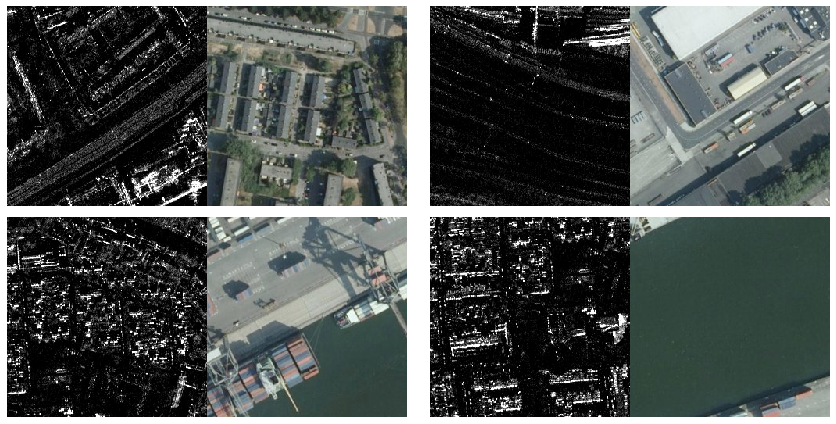

In [4]:
data.show_batch()

### Load model architecture

In [10]:
model = CycleGAN(data)

### Find an optimal learning rate

[Learning rate](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) is one of the most important hyperparameters in model training. ArcGIS API for Python provides a learning rate finder that automatically chooses the optimal learning rate for you.

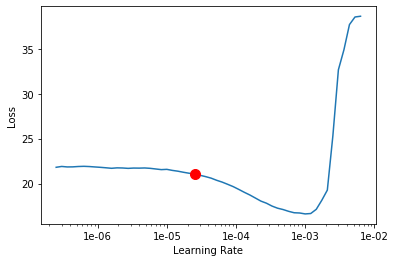

2.5118864315095795e-05

In [11]:
lr = model.lr_find()

### Fit the model 

We will train the model for a few epochs with the learning rate we have found. For the sake of time, we can start with 25 epochs. Unlike some other models, we train CycleGAN from scratch with a learning rate of 2e-04 for some initial epochs and then linearly decay the rate to zero over the next epochs.

In [7]:
model.fit(25, lr=2e-04)

epoch,train_loss,valid_loss,id_loss,gen_loss,cyc_loss,D_A_loss,D_B_loss,time
0,5.317568,5.336852,1.550138,0.720733,3.046698,0.197484,0.222046,14:07
1,4.908140,6.136398,1.340261,0.861988,2.705891,0.741538,0.336392,13:25
2,4.412481,6.278461,1.163109,0.792766,2.456607,0.378034,1.073672,13:12
3,4.182445,5.562617,1.068715,0.757754,2.355975,0.337290,0.837495,13:05
4,3.957423,8.413357,0.987927,0.762105,2.207391,1.589632,0.346265,12:59
5,3.947841,7.707170,0.948394,0.789307,2.210140,1.373522,0.279166,12:57
6,3.989404,4.538482,0.926119,0.914255,2.149030,0.349952,0.396675,12:58
7,3.877221,4.926952,0.904841,0.927214,2.045167,0.197091,0.258876,12:57
8,3.626200,8.130665,0.815586,0.895576,1.915039,0.562384,0.816195,12:55
9,3.548248,5.545265,0.804024,0.842509,1.901715,0.836604,0.434236,12:51


Here, with 25 epochs, we can see reasonable results — both training and validation losses have gone down considerably, indicating that the model is learning to translate SAR imagery to RGB and vice versa.

### Visualize results in validation set

It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

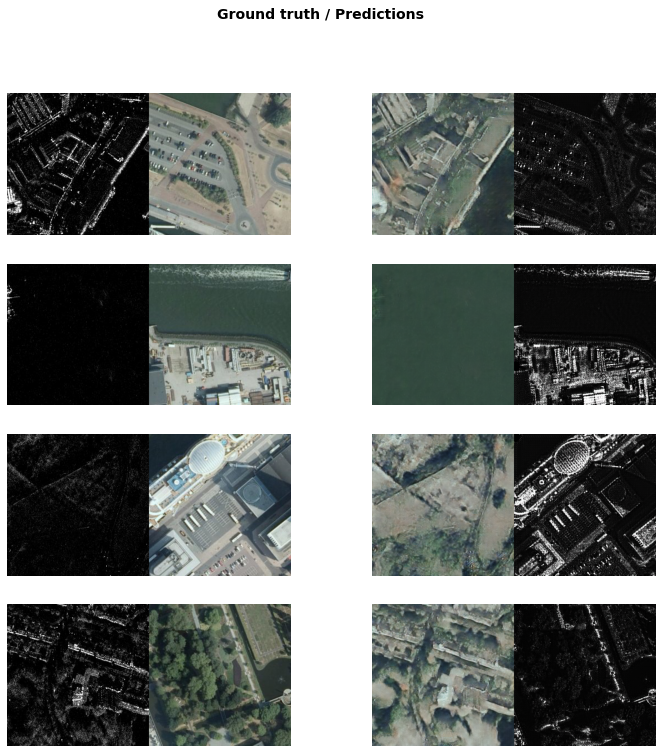

In [8]:
model.show_results()

### Save the model

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [13]:
model.save("SAR_to_RGB_25e", publish=True)    

WindowsPath('D:/CycleGAN/Data/data_for_cyclegan_le_3Bands/models/SAR_to_RGB_25e')

## Model inference

We can translate SAR imagery to RGB and vice versa with the help of `predict()` method.

Using predict function, we can apply the trained model on the image which we want to translate.
- `img_path`: path to the image file.
- `convert_to`: 'a' or 'b' type of fake image we want to generate.

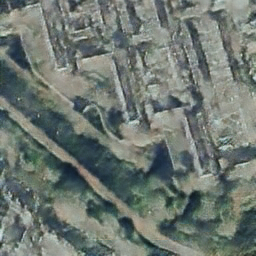

In [12]:
#un-comment the cell to run predict over your desired image.
# model.predict(r"D:\CycleGAN\Data\data_for_cyclegan_le_3Bands\Images\train_a\000000005.jpg", convert_to="b")

In the above step, we are translating an image of `type a` i.e. SAR imagery to an image of `type b` i.e. RGB imagery. We can also perform `type b` to `type a` translation by changing the image file and `convert_to` parameter.

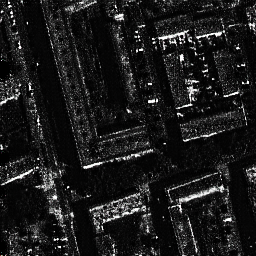

In [14]:
#un-comment the cell to run predict over your desired image.
# model.predict(r"D:\CycleGAN\Data\data_for_cyclegan_le_3Bands\Images\train_b\000000008.jpg", convert_to="a")

## Conclusion 

In this notebook, we demonstrated how to use `CycleGAN` model using `ArcGIS API for Python` in order to translate imagery of one type to the other.

## References 

[1] Jun-Yan Zhu, Taesung Park, Phillip Isola, Alexei A. Efros: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks; https://arxiv.org/abs/1703.10593.